In [1]:
import itertools
import math
import re
from math import radians, cos, sin, asin, sqrt

import numpy as np
import pandas as pd
from pandas import Timestamp
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

pd.options.mode.chained_assignment = None  # default='warn'

In [58]:
path = %pwd
accident_df = pd.read_csv(path + "\Data\\AccidentsData.csv", low_memory=False)
weather_df = pd.read_csv(path + "\Data\\Weather_original.csv", low_memory=False, encoding= 'unicode_escape')

# 1. Data Pre-process

In [1]:
# These part of data containing the following part:
#     data cleaning
#     the missing data complemented by other information
#     weather data merge

## 1-1 Accident data cleaning

In [59]:
# First five rows of original data
accident_df

CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0        3/1/2019      10:30        NaN       NaN        NaN        NaN   
1        3/1/2019      13:25        NaN       NaN  40.688614 -73.999435   
2        3/1/2019       7:10  MANHATTAN   10128.0  40.781944 -73.945680   
3        3/1/2019      16:50        NaN       NaN        NaN        NaN   
4        3/1/2019      11:25  MANHATTAN   10012.0  40.726593 -73.995964   
...           ...        ...        ...       ...        ...        ...   
306007  2/28/2021      15:37  MANHATTAN   10128.0  40.781895 -73.959160   
306008  2/28/2021       1:40        NaN       NaN  40.866820 -73.839230   
306009  2/28/2021      16:43   BROOKLYN   11222.0  40.725098 -73.946815   
306010  2/28/2021       8:58     QUEENS   11377.0  40.738556 -73.905396   
306011  2/28/2021      17:58   BROOKLYN   11208.0  40.670193 -73.878876   

                       LOCATION                    ON STREET NAME  \
0                           NaN  DAHLIA AVENUE                      
1       (40.688614, -73.999435)  WARREN STREET                      
2        (40.781944, -73.94568)  1 AVENUE                           
3                           NaN  STATEN ISLAND EXPRESSWAY           
4       (40.726593, -73.995964)                               NaN   
...                         ...                               ...   
306007   (40.781895, -73.95916)                               NaN   
306008    (40.86682, -73.83923)  EAST GUN HILL ROAD                 
306009  (40.725098, -73.946815)                               NaN   
306010  (40.738556, -73.905396)                               NaN   
306011  (40.670193, -73.878876)  BLAKE AVENUE                       

       CROSS STREET NAME                           OFF STREET NAME  ...  \
0                    NaN                                       NaN  ...   
1           HICKS STREET                                       NaN  ...   
2         EAST 94 STREET                                       NaN  ...   
3                    NaN                                       NaN  ...   
4                    NaN  75        BLEECKER STREET                 ...   
...                  ...                                       ...  ...   
306007               NaN  17        EAST 87 STREET                  ...   
306008  KINGSLAND AVENUE                                       NaN  ...   
306009               NaN  163       NASSAU AVENUE                   ...   
306010               NaN  59-34     48 AVENUE                       ...   
306011   BERRIMAN STREET                                       NaN  ...   

        CONTRIBUTING FACTOR VEHICLE 2  CONTRIBUTING FACTOR VEHICLE 3  \
0                         Unspecified                            NaN   
1                         Unspecified                            NaN   
2                         Unspecified                            NaN   
3                         Unspecified                            NaN   
4                         Unspecified                            NaN   
...                               ...                            ...   
306007                    Unspecified                    Unspecified   
306008                Other Vehicular            Alcohol Involvement   
306009                    Unspecified                    Unspecified   
306010                    Unspecified                            NaN   
306011                Other Vehicular                            NaN   

        CONTRIBUTING FACTOR VEHICLE 4  CONTRIBUTING FACTOR VEHICLE 5  \
0                                 NaN                            NaN   
1                                 NaN                            NaN   
2                                 NaN                            NaN   
3                                 NaN                            NaN   
4                                 NaN                            NaN   
...                               ...                            ...   
306007 

### 1-1-1. Retrieving missing borough, zipcode, and onstreet name

In [60]:
# Exclude data without Latitude and Longitude
accident_df = accident_df.dropna(subset = ["LATITUDE", "LONGITUDE"])

# Exclude data with Latitude and Longitude are set to 0
accident_df = accident_df[accident_df["LATITUDE"] != 0]
accident_df = accident_df[accident_df["LONGITUDE"] != 0]

# Filter rows where either borough, zipcode, onstreet name are missing and set to df_temp1
df_temp1 = accident_df[accident_df["BOROUGH"].isnull() | accident_df["ZIP CODE"].isnull() | accident_df["ON STREET NAME"].isnull()]
df_temp1 = df_temp1.reset_index().drop("index", axis = 1)

# Save rest of the rows (no missing) as df_temp2
df_temp2 = pd.concat([accident_df, df_temp1, df_temp1]).drop_duplicates(keep=False)



# Below commented rows of code find missing borough, zipcode, and onstreet name using geopy
# However, it takes approximately 20 hours to run the code and find more than 100,000 missing data.
# So rows are commented and completed csv file is loaded instead at the end
"""
# Definition that input latitude and longitude, output address
def get_zipcode2(geolocator, lati, long):
    location = geolocator.reverse((lati, long))
    return location.raw['address']

# Call geopy API
geolocator = geopy.Nominatim(user_agent='sunghwan1990@gmail.com')

# Get latitude and longitude of df_temp1 (rows missing either borough, zipcode, onstreet name)
lati_list = list(df_temp1["LATITUDE"])
long_list = list(df_temp1["LONGITUDE"])

# Create empty lists to save retrieved borough, zipcode, and onstreet name
borough = []
street_name = []
zip_code = []

# From address found by geopy, filter borough, zipcode, onstreet name and append to lists
for i in range(0, len(lati_list)):
    print(i)
    try:
        borough.append(get_zipcode2(geolocator, lati_list[i], long_list[i])["suburb"])
    except:
        borough.append(None)
        pass
    try:
        street_name.append(get_zipcode2(geolocator, lati_list[i], long_list[i])["road"])
    except:
        street_name.append(None)
        pass
    try:
        zip_code.append(get_zipcode2(geolocator, lati_list[i], long_list[i])["postcode"])
    except:
        zip_code.append(None)
        pass

# Create dataframe containing retreived borough, zipcode, and onstreet name
df_retrived = pd.DataFrame({"BOROUGH": borough, "ZIP CODE": zip_code, "LATITUDE": lati_list, "LONGITUDE":long_list, "ON STREET NAME":street_name})
"""

# Load completed csv file that has retreived borough, zipcode, and onstreet name
df_retrived = pd.read_csv(path + "\Data\\no_info_retrieved.csv", low_memory=False)

# Fix the column names and values to lowercase or uppercase
df_retrived.columns = map(str.lower, df_retrived.columns)
df_retrived = df_retrived.apply(lambda x: x.str.upper() if x.dtype == "object" else x) 
df_retrived = df_retrived.replace({"borough": {"THE BRONX": "BRONX", "QUEENS COUNTY": "QUEENS", "BELLEROSE": "QUEENS", "RICHMOND COUNTY": "STATEN ISLAND"}})

# Fix zipcode errors
df_retrived["zip code"] = df_retrived["zip code"].str.split('-').str[0]
df_retrived["zip code"] = df_retrived["zip code"].str.split(':').str[0]
df_retrived = df_retrived.replace({"zip code" : { "100": "10019", "381": "10028", "1224": "11224", "7206": "10303"
                                 , "112321": "11231", "111354": "11367", "100036": "10036", "100014": "10014"
                                 , "12692": "11692", "7024": "10032"}})

# Concat accident data and retrieved infomation data
df_temp1 = pd.concat([df_temp1, df_retrived], axis = 1)

# Fill in the na values on accident data with retrieved data
df_temp1["BOROUGH"] = df_temp1["BOROUGH"].fillna(df_temp1["borough"])
df_temp1["ZIP CODE"] = df_temp1["ZIP CODE"].fillna(df_temp1["zip code"])
df_temp1["ON STREET NAME"] = df_temp1["ON STREET NAME"].fillna(df_temp1["on street name"])

# Delete columns from retrieved data
df_temp1 = df_temp1.drop(["borough", "zip code", "latitude", "longitude", "on street name"], axis = 1)

# Concat divided accident data (part retrieved and part those had all the data)
accident_df = pd.concat([df_temp1, df_temp2], axis = 0)
accident_df = accident_df.dropna(subset=["BOROUGH", "ZIP CODE"])
accident_df

CRASH DATE CRASH TIME        BOROUGH ZIP CODE   LATITUDE  LONGITUDE  \
0        3/1/2019      13:25       BROOKLYN    11201  40.688614 -73.999435   
1        3/1/2019      11:25      MANHATTAN    10012  40.726593 -73.995964   
2        3/1/2019       7:40  STATEN ISLAND    10309  40.525616 -74.229416   
3        3/1/2019       9:15         QUEENS    11420  40.678837 -73.827194   
4        3/1/2019      16:40       BROOKLYN    11212  40.663227 -73.931590   
...           ...        ...            ...      ...        ...        ...   
305998  2/28/2021      14:30         QUEENS    11420  40.668224 -73.818680   
306001  2/28/2021       0:00         QUEENS    11433  40.694010 -73.778640   
306003  2/28/2021      19:35       BROOKLYN    11228  40.606842 -74.015500   
306004  2/28/2021      18:00       BROOKLYN    11217  40.677998 -73.973060   
306011  2/28/2021      17:58       BROOKLYN    11208  40.670193 -73.878876   

                       LOCATION                    ON STREET NAME  \
0       (40.688614, -73.999435)  WARREN STREET                      
1       (40.726593, -73.995964)                   BLEECKER STREET   
2       (40.525616, -74.229416)  WEST SHORE EXPRESSWAY              
3       (40.678837, -73.827194)  112 STREET                         
4        (40.663227, -73.93159)  UTICA AVENUE                       
...                         ...                               ...   
305998   (40.668224, -73.81868)  149 AVENUE                         
306001    (40.69401, -73.77864)  SAYRES AVENUE                      
306003    (40.606842, -74.0155)  CROPSEY AVENUE                     
306004   (40.677998, -73.97306)  7 AVENUE                           
306011  (40.670193, -73.878876)  BLAKE AVENUE                       

       CROSS STREET NAME                           OFF STREET NAME  ...  \
0           HICKS STREET                                       NaN  ...   
1                    NaN  75        BLEECKER STREET                 ...   
2                    NaN                                       NaN  ...   
3                    NaN                                       NaN  ...   
4                    NaN                                       NaN  ...   
...                  ...                                       ...  ...   
305998        122 STREET                                       NaN  ...   
306001        173 STREET                                       NaN  ...   
306003      BAY 8 STREET                                       NaN  ...   
306004   FLATBUSH AVENUE                                       NaN  ...   
306011   BERRIMAN STREET                                       NaN  ...   

        CONTRIBUTING FACTOR VEHICLE 2  CONTRIBUTING FACTOR VEHICLE 3  \
0                         Unspecified                            NaN   
1                         Unspecified                            NaN   
2                                 NaN                            NaN   
3                         Unspecified                            NaN   
4               Following Too Closely                    Unspecified   
...                               ...                            ...   
305998                    Unspecified                            NaN   
306001                    Unspecified                            NaN   
306003                    Unspecified                            NaN   
306004                    Unspecified                            NaN   
306011                Other Vehicular                            NaN   

        CONTRIBUTING FACTOR VEHICLE 4  CONTRIBUTING FACTOR VEHICLE 5  \
0                                 NaN                            NaN   
1                                 NaN                            NaN   
2                                 NaN                            NaN   
3                                 NaN                            NaN   
4                                 NaN                            NaN   
...                               ...      

### 1-1-2. Merging date and time column

In [61]:
# Merge crash data and time, convert to datetime data
accident_df["Datetime"] = accident_df["CRASH DATE"] + " " + accident_df["CRASH TIME"]
accident_df["Datetime"] =  pd.to_datetime(accident_df["Datetime"])
accident_df = accident_df.rename(columns={"LATITUDE": "Latitude", "LONGITUDE": "Longitude"})

# Reorder columns
column_list = list(accident_df.columns)[2:][-1:] + list(accident_df.columns)[2:][:-1] 
accident_df = accident_df[column_list]

# Show head of cleaned accident data
accident_df.head()

Datetime        BOROUGH ZIP CODE   Latitude  Longitude  \
0 2019-03-01 13:25:00       BROOKLYN    11201  40.688614 -73.999435   
1 2019-03-01 11:25:00      MANHATTAN    10012  40.726593 -73.995964   
2 2019-03-01 07:40:00  STATEN ISLAND    10309  40.525616 -74.229416   
3 2019-03-01 09:15:00         QUEENS    11420  40.678837 -73.827194   
4 2019-03-01 16:40:00       BROOKLYN    11212  40.663227 -73.931590   

                  LOCATION                    ON STREET NAME  \
0  (40.688614, -73.999435)  WARREN STREET                      
1  (40.726593, -73.995964)                   BLEECKER STREET   
2  (40.525616, -74.229416)  WEST SHORE EXPRESSWAY              
3  (40.678837, -73.827194)  112 STREET                         
4   (40.663227, -73.93159)  UTICA AVENUE                       

  CROSS STREET NAME                           OFF STREET NAME  \
0      HICKS STREET                                       NaN   
1               NaN  75        BLEECKER STREET                  
2               NaN                                       NaN   
3               NaN                                       NaN   
4               NaN                                       NaN   

   NUMBER OF PERSONS INJURED  ...  CONTRIBUTING FACTOR VEHICLE 2  \
0                        0.0  ...                    Unspecified   
1                        0.0  ...                    Unspecified   
2                        0.0  ...                            NaN   
3                        0.0  ...                    Unspecified   
4                        0.0  ...          Following Too Closely   

   CONTRIBUTING FACTOR VEHICLE 3  CONTRIBUTING FACTOR VEHICLE 4  \
0                            NaN                            NaN   
1                            NaN                            NaN   
2                            NaN                            NaN   
3                            NaN                            NaN   
4                    Unspecified                            NaN   

   CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
0                            NaN       4089224   
1                            NaN       4089748   
2                            NaN       4090697   
3                            NaN       4089199   
4                            NaN       4090270   

                   VEHICLE TYPE CODE 1                  VEHICLE TYPE CODE 2  \
0                                TRUCK                                Sedan   
1                                Sedan  Station Wagon/Sport Utility Vehicle   
2  Station Wagon/Sport Utility Vehicle                                  NaN   
3                                Sedan  Station Wagon/Sport Utility Vehicle   
4                                Sedan                                Sedan   

  VEHICLE TYPE CODE 3 VEHICLE TYPE CODE 4 VEHICLE TYPE CODE 5  
0                 NaN                 NaN                 NaN  
1                 NaN                 NaN                 NaN  
2                 NaN                 NaN                 NaN  
3                 NaN                 NaN                 NaN  
4                 NaN                 NaN                 NaN  

[5 rows x 28 columns]

## 1-2. Weather data cleaning

In [62]:
# First five rows of original data
weather_df

STATION                 DATE REPORT_TYPE SOURCE  AWND  \
0       72503014732  2019-02-27T00:51:00       FM-15      7   NaN   
1       72503014732  2019-02-27T01:00:00       FM-12      4   NaN   
2       72503014732  2019-02-27T01:51:00       FM-15      7   NaN   
3       72503014732  2019-02-27T02:51:00       FM-15      7   NaN   
4       72503014732  2019-02-27T03:51:00       FM-15      7   NaN   
...             ...                  ...         ...    ...   ...   
152719  72502014734  2021-03-04T20:51:00       FM-15      7   NaN   
152720  72502014734  2021-03-04T21:51:00       FM-15      7   NaN   
152721  72502014734  2021-03-04T22:51:00       FM-15      7   NaN   
152722  72502014734  2021-03-04T23:51:00       FM-15      7   NaN   
152723  72502014734  2021-03-04T23:59:00       SOD        6   NaN   

       BackupDirection  BackupDistance BackupDistanceUnit      BackupElements  \
0                  NaN             NaN                NaN                 NaN   
1                  NaN             NaN                NaN                 NaN   
2                  NaN             NaN                NaN                 NaN   
3                  NaN             NaN                NaN                 NaN   
4                  NaN             NaN                NaN                 NaN   
...                ...             ...                ...                 ...   
152719             SSE            0.75                 mi  TEMP, PRECIP, SNOW   
152720             SSE            0.75                 mi  TEMP, PRECIP, SNOW   
152721             SSE            0.75                 mi  TEMP, PRECIP, SNOW   
152722             SSE            0.75                 mi  TEMP, PRECIP, SNOW   
152723             SSE            0.75                 mi  TEMP, PRECIP, SNOW   

        BackupElevation  ...  ShortDurationPrecipitationValue045  \
0                   NaN  ...                                 NaN   
1                   NaN  ...                                 NaN   
2                   NaN  ...                                 NaN   
3                   NaN  ...                                 NaN   
4                   NaN  ...                                 NaN   
...                 ...  ...                                 ...   
152719              NaN  ...                                 NaN   
152720              NaN  ...                                 NaN   
152721              NaN  ...                                 NaN   
152722              NaN  ...                                 NaN   
152723              NaN  ...                                 NaN   

       ShortDurationPrecipitationValue060  ShortDurationPrecipitationValue080  \
0                                     NaN                                 NaN   
1                                     NaN                                 NaN   
2                                     NaN                                 NaN   
3                                     NaN                                 NaN   
4                                     NaN                                 NaN   
...                                   ...                                 ...   
152719                                NaN                                 NaN   
152720                                NaN                                 NaN   
152721                                NaN                                 NaN   
152722                                NaN                                 NaN   
152723                                NaN                                 NaN   

        ShortDurationPrecipitationValue100 ShortDurationPrecipitationValue120  \
0                                      NaN                                NaN   
1                                      NaN                                NaN   
2                                      NaN                                NaN   
3                                      NaN                                NaN   
4              

In [63]:
# Original data info
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152724 entries, 0 to 152723
Columns: 124 entries, STATION to WindEquipmentChangeDate
dtypes: float64(78), int64(1), object(45)
memory usage: 144.5+ MB


In [64]:
# Choose columns to work on
weather_df = weather_df[["STATION", "DATE", "HourlyDryBulbTemperature", "HourlyPrecipitation"
         , "HourlyPresentWeatherType", "HourlyRelativeHumidity", "HourlyVisibility", "Sunrise", "Sunset"]]

# Rename the columns to shorter names
weather_df = weather_df.rename(columns={"STATION": "Station", "DATE": "Datetime", "HourlyDryBulbTemperature": "DBTemp(F)"
                        , "HourlyRelativeHumidity": "RelHum(%)", "HourlyVisibility": "Visibility(mi)"
                        , "HourlyPrecipitation": "Precip(in)", "HourlyPresentWeatherType": "Weathercode"})

# Reorder the columns
weather_df = weather_df[["Station", "Datetime", "DBTemp(F)", "RelHum(%)", "Precip(in)", "Visibility(mi)", "Weathercode", "Sunrise", "Sunset"]]

# Change type to datetime
weather_df["Datetime"] =  pd.to_datetime(weather_df["Datetime"])

# Create dataframe that saves daily sunrise and sunset time data
df_sun = weather_df.dropna(subset = ["Sunset"])
df_sun = df_sun[df_sun["Station"] == 72505394728]
df_sun = df_sun[["Datetime", "Sunrise", "Sunset"]]
df_sun['just_date'] = df_sun['Datetime'].dt.date
df_sun = df_sun.drop(["Datetime"], axis = 1)

# Input sunrise and sunset time on each row of weather data
weather_df['just_date'] = weather_df["Datetime"].dt.date
weather_df = weather_df.drop(["Sunrise", "Sunset"], axis = 1)
weather_df = pd.merge(weather_df, df_sun, on='just_date')


# Filter unwanted times and resample data into hourly interval
weather_df = weather_df[(weather_df["Datetime"].dt.minute == 51) | (weather_df["Datetime"].dt.minute == 15)]
weather_df["Datetime"] = weather_df["Datetime"].round('60min')
weather_df = weather_df.drop_duplicates(subset=["Station", "Datetime"])
weather_df = weather_df.sort_values(["Station", "Datetime"], ascending = True).set_index("Datetime")
weather_df = weather_df.groupby("Station").resample('H').pad()
weather_df = weather_df.drop(["Station", "just_date"], axis = 1).reset_index(level=0)

# Select specific time range that match with accident data
weather_df = weather_df.loc['2019-03-01 00:00:00':'2021-02-28 23:00:00'].reset_index(level=0)

# Create daylight column (telling whether there is a daylight) based on sunrise and sunset time
weather_df["Sunrise"] = pd.to_datetime(weather_df["Sunrise"], format='%H%M', exact=False).dt.time
weather_df["Sunset"] = pd.to_datetime(weather_df["Sunset"], format='%H%M', exact=False).dt.time
weather_df["Daylight"] = np.where((weather_df["Datetime"].dt.time >= weather_df["Sunrise"])&(weather_df["Datetime"].dt.time <= weather_df["Sunset"]), True, False)
weather_df = weather_df.drop(["Sunrise", "Sunset"], axis = 1)

# Clean precipitation, dry blub temperature, relative humidity, visibility columns
weather_df["Precip(in)"] = weather_df["Precip(in)"].replace(r'[A-Z]|[a-z]', "", regex = True).replace(r'', np.NaN).fillna(0)
weather_df["DBTemp(F)"] = weather_df["DBTemp(F)"].replace(r'[A-Z]|[a-z]', "", regex = True).replace(r'', np.NaN).fillna(method='ffill')
weather_df["RelHum(%)"] = weather_df["RelHum(%)"].replace(r'[A-Z]|[a-z]', "", regex = True).replace(r'', np.NaN).fillna(method='ffill')
weather_df["Visibility(mi)"] = weather_df["Visibility(mi)"].replace(r'[A-Z]|[a-z]', "", regex = True).replace(r'', np.NaN).replace("*", np.NaN).fillna(method='ffill')
weather_df[["DBTemp(F)", "Precip(in)", "Visibility(mi)"]] = weather_df[["DBTemp(F)", "Precip(in)", "Visibility(mi)"]].astype(float)
weather_df["Datetime"] =  pd.to_datetime(weather_df["Datetime"])

# Create weather event columns base on wethercode of NOAA
w_event = {"RA": "Rain", "SN": "Snow"}

for i in range(len(w_event.keys())):
    weather_df[list(w_event.values())[i]] = weather_df["Weathercode"].str.contains(list(w_event.keys())[i])
    weather_df = weather_df.fillna(False)
weather_df = weather_df.drop("Weathercode", axis = 1)

# Input location data base on weather staion code
s_loc = {72058100178: ["Linden ap", 40.617, -74.25], 72502014734: ["Newark ap", 40.6825, -74.1694]
         , 72503014732: ["Laguardia ap", 40.77944, -73.88035], 72505394728: ["Central Park", 40.77898, -73.96925]
         , 74486094789: ["JFK ap", 40.63915, -73.76401]}
for i in range(len(s_loc.keys())):
    weather_df.loc[weather_df["Station"] == list(s_loc.keys())[i], ["Station", "Latitude", "Longitude"]] = list(s_loc.values())[i][0], list(s_loc.values())[i][1], list(s_loc.values())[i][2]

# Reorder columns
weather_df = weather_df[weather_df.columns[[0, 1, 9, 10, 2, 3, 4, 5, 6, 7, 8]]]


# Show head of cleaned weather data
weather_df

Datetime    Station  Latitude  Longitude  DBTemp(F)  \
0     2019-03-01 00:00:00  Linden ap  40.61700  -74.25000       31.0   
1     2019-03-01 01:00:00  Linden ap  40.61700  -74.25000       31.0   
2     2019-03-01 02:00:00  Linden ap  40.61700  -74.25000       31.0   
3     2019-03-01 03:00:00  Linden ap  40.61700  -74.25000       31.0   
4     2019-03-01 04:00:00  Linden ap  40.61700  -74.25000       31.0   
...                   ...        ...       ...        ...        ...   
87715 2021-02-28 19:00:00     JFK ap  40.63915  -73.76401       42.0   
87716 2021-02-28 20:00:00     JFK ap  40.63915  -73.76401       41.0   
87717 2021-02-28 21:00:00     JFK ap  40.63915  -73.76401       42.0   
87718 2021-02-28 22:00:00     JFK ap  40.63915  -73.76401       43.0   
87719 2021-02-28 23:00:00     JFK ap  40.63915  -73.76401       44.0   

       RelHum(%)  Precip(in)  Visibility(mi)  Daylight   Rain   Snow  
0           35.0        0.00            10.0     False  False  False  
1           35.0        0.00            10.0     False  False  False  
2           39.0        0.00            10.0     False  False  False  
3           43.0        0.00            10.0     False  False  False  
4           45.0        0.00            10.0     False  False  False  
...          ...         ...             ...       ...    ...    ...  
87715       89.0        0.00             7.0     False  False  False  
87716       93.0        0.02             2.5     False   True  False  
87717       92.0        0.02             2.5     False   True  False  
87718       93.0        0.02             1.0     False   True  False  
87719       96.0        0.02             1.0     False   True  False  

[87720 rows x 11 columns]

## 1-3. Match accident data and weather data

In [65]:
# This part takes 3~4 minutes to run

# function calculating distance between two locations by latitude and longitude
def dist(lat1, long1, lat2, long2):
    # convert decimal degrees to radians 
    lat1, long1, lat2, long2 = map(radians, [lat1, long1, lat2, long2])
    # haversine formula 
    dlon = long2 - long1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371* c
    return km

# function finding the nearest weather station by comparing distance
def find_nearest(lat, long):
    distances = df_loc.apply(lambda x: dist(lat, long, x["Latitude"], x["Longitude"]), axis=1)
    return df_loc.loc[distances.idxmin(), "Station"]

# Create dataframe with station name, latitude, and longitude
dic_loc = {"Linden ap": [40.617, -74.25], "Newark ap": [40.6825, -74.1694], "Laguardia ap": [40.77944, -73.88035]
           , "Central Park": [40.77898, -73.96925], "JFK ap": [40.63915, -73.76401]}
df_loc = pd.DataFrame(dic_loc).transpose().reset_index()
df_loc = df_loc.rename(columns={"index": "Station", 0: "Latitude", 1: "Longitude"})

# Find the nearest station for each accident data
accident_df["Station"] = accident_df.apply(lambda x: find_nearest(x["Latitude"], x["Longitude"]), axis=1)
accident_df = accident_df.sort_values("Datetime", ascending = True)


# Match the accident data and weather data by station name, and closest time
for i in range(len(list(dic_loc.keys()))):
    df = pd.merge_asof(accident_df.loc[accident_df["Station"] == list(dic_loc.keys())[i]]
                       , weather_df.loc[weather_df["Station"] == list(dic_loc.keys())[i]], on = "Datetime" , direction='nearest')
    if i == 0:
        df_merged = df
        continue
    df_merged = pd.concat([df_merged, df],ignore_index=True)

# Clean the column names
df_merged = df_merged.drop(["Station_y", "Latitude_y", "Longitude_y"], axis = 1)
df_merged = df_merged.rename(columns={"Latitude_x": "Latitude", "Longitude_x": "Longitude", "Station_x": "Station"})


df_merged

Datetime        BOROUGH ZIP CODE   Latitude  Longitude  \
0      2019-03-01 00:15:00  STATEN ISLAND    10307  40.515965 -74.243880   
1      2019-03-01 07:40:00  STATEN ISLAND    10309  40.525616 -74.229416   
2      2019-03-01 08:00:00  STATEN ISLAND    10312  40.544650 -74.165500   
3      2019-03-01 08:40:00  STATEN ISLAND    10312  40.547108 -74.166210   
4      2019-03-01 09:43:00  STATEN ISLAND    10314  40.576965 -74.169740   
...                    ...            ...      ...        ...        ...   
280782 2021-02-28 21:00:00         QUEENS    11419  40.683666 -73.825780   
280783 2021-02-28 21:00:00         QUEENS    11691  40.593460 -73.777985   
280784 2021-02-28 21:50:00         QUEENS    11412  40.692380 -73.762436   
280785 2021-02-28 21:58:00       BROOKLYN    11207  40.653854 -73.896660   
280786 2021-02-28 22:30:00       BROOKLYN    11236  40.650402 -73.894220   

                       LOCATION                    ON STREET NAME  \
0        (40.515965, -74.24388)                      ELLIS STREET   
1       (40.525616, -74.229416)  WEST SHORE EXPRESSWAY              
2          (40.54465, -74.1655)  RICHMOND AVENUE                    
3        (40.547108, -74.16621)  RICHMOND AVENUE                    
4        (40.576965, -74.16974)  RICHMOND AVENUE                    
...                         ...                               ...   
280782   (40.683666, -73.82578)  107 AVENUE                         
280783   (40.59346, -73.777985)  BEACH 47 STREET                    
280784   (40.69238, -73.762436)  FARMERS BOULEVARD                  
280785   (40.653854, -73.89666)                    STANLEY AVENUE   
280786   (40.650402, -73.89422)  EAST 108 STREET                    

               CROSS STREET NAME                           OFF STREET NAME  \
0                            NaN  113       ELLIS STREET                     
1                            NaN                                       NaN   
2                  SYLVIA STREET                                       NaN   
3                  PETRUS AVENUE                                       NaN   
4                   YUKON AVENUE                                       NaN   
...                          ...                                       ...   
280782                116 STREET                                       NaN   
280783  ROCKAWAY BEACH BOULEVARD                                       NaN   
280784             DUNKIRK DRIVE                                       NaN   
280785                       NaN  254       STANLEY AVENUE                   
280786             GLENWOOD ROAD                                       NaN   

        NUMBER OF PERSONS INJURED  ...  VEHICLE TYPE CODE 4  \
0                             0.0  ...                  NaN   
1                             0.0  ...                  NaN   
2                             0.0  ...                  NaN   
3                             0.0  ...                  NaN   
4                             0.0  ...                  NaN   
...                           ...  ...                  ...   
280782                        2.0  ...                Sedan   
280783                        0.0  ...                  NaN   
280784                        0.0  ...                  NaN   
280785                        0.0  ...                  NaN   
280786                        2.0  ...                  NaN   

        VEHICLE TYPE CODE 5    Station  DBTemp(F)  RelHum(%)  Precip(in)  \
0                       NaN  Linden ap       31.0       35.0        0.00   
1                       NaN  Linden ap       28.0       87.0        0.00   
2                       NaN  Linden ap       28.0       87.0        0.00   
3                       NaN  Linden ap       29.0       86.0        0.00   
4                       NaN  Linden ap       30.0       85.0        0.00   
...                     ...        ...        ...        ...         ...   
280782                Sedan     JFK ap       42.0 

In [66]:
df_merged.to_csv(path + "\Data\\Accident+weather_merged.csv", index = False)

# 2. Data Process

## 2-1. Create New Dataset

In [2]:
# Read the data into pandas dataframes
accident = pd.read_csv("./data/Accident+weather_merged.csv")
accident.head(5)

Datetime        BOROUGH  ZIP CODE   Latitude  Longitude  \
0  2019-03-01 00:15:00  STATEN ISLAND   10307.0  40.515965 -74.243880   
1  2019-03-01 07:40:00  STATEN ISLAND   10309.0  40.525616 -74.229416   
2  2019-03-01 08:00:00  STATEN ISLAND   10312.0  40.544650 -74.165500   
3  2019-03-01 08:40:00  STATEN ISLAND   10312.0  40.547108 -74.166210   
4  2019-03-01 09:43:00  STATEN ISLAND   10314.0  40.576965 -74.169740   

                  LOCATION                    ON STREET NAME  \
0   (40.515965, -74.24388)                      ELLIS STREET   
1  (40.525616, -74.229416)  WEST SHORE EXPRESSWAY              
2     (40.54465, -74.1655)  RICHMOND AVENUE                    
3   (40.547108, -74.16621)  RICHMOND AVENUE                    
4   (40.576965, -74.16974)  RICHMOND AVENUE                    

  CROSS STREET NAME                           OFF STREET NAME  \
0               NaN  113       ELLIS STREET                     
1               NaN                                       NaN   
2     SYLVIA STREET                                       NaN   
3     PETRUS AVENUE                                       NaN   
4      YUKON AVENUE                                       NaN   

   NUMBER OF PERSONS INJURED  ...  VEHICLE TYPE CODE 4  VEHICLE TYPE CODE 5  \
0                        0.0  ...                  NaN                  NaN   
1                        0.0  ...                  NaN                  NaN   
2                        0.0  ...                  NaN                  NaN   
3                        0.0  ...                  NaN                  NaN   
4                        0.0  ...                  NaN                  NaN   

     Station  DBTemp(F)  RelHum(%)  Precip(in)  Visibility(mi) Daylight  \
0  Linden ap       31.0       35.0         0.0            10.0    False   
1  Linden ap       28.0       87.0         0.0             4.0     True   
2  Linden ap       28.0       87.0         0.0             4.0     True   
3  Linden ap       29.0       86.0         0.0             7.0     True   
4  Linden ap       30.0       85.0         0.0             5.0     True   

    Rain   Snow  
0  False  False  
1  False  False  
2  False  False  
3  False  False  
4  False  False  

[5 rows x 36 columns]

In [3]:
# Create two list to trace the categorical and numerical perdictors
categorical = ['BOROUGH', 'Daylight', 'Rain', 'Snow']
numerical = ['DBTemp(F)', 'RelHum(%)', 'Precip(in)', 'Visibility(mi)']
indexical = ['ZIP CODE']

# Create a clean dataset to store the model variables
accident_df = accident[categorical + numerical + indexical]

In [4]:
accident_df.head(5)

BOROUGH  Daylight   Rain   Snow  DBTemp(F)  RelHum(%)  Precip(in)  \
0  STATEN ISLAND     False  False  False       31.0       35.0         0.0   
1  STATEN ISLAND      True  False  False       28.0       87.0         0.0   
2  STATEN ISLAND      True  False  False       28.0       87.0         0.0   
3  STATEN ISLAND      True  False  False       29.0       86.0         0.0   
4  STATEN ISLAND      True  False  False       30.0       85.0         0.0   

   Visibility(mi)  ZIP CODE  
0            10.0   10307.0  
1             4.0   10309.0  
2             4.0   10312.0  
3             7.0   10312.0  
4             5.0   10314.0

## 2-2. Predictors Process

### 2-2-1. Predictor Collision_count

In [5]:
# number of vehicle collision
accident_df_collision = accident[['VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']]
accident_df_collision['Number of Collision'] = (accident_df_collision.notna() * 1).sum(axis=1)

# Add new grouped value to original dataset
accident_df['Collision_count'] = accident_df_collision['Number of Collision']

# Add variable
if 'Collision_count' not in numerical:
    numerical.append('Collision_count')

### 2-2-2. Predictor Time_cat

In [6]:
# Get current date 
today = pd.to_datetime("today").strftime('%Y-%m-%d')

# Construct time categories code
time_period = [
    f'{today} 00:00',      # 0
    f'{today} 03:00',      # 1
    f'{today} 06:00',      # 2
    f'{today} 09:00',      # 3
    f'{today} 12:00',      # 4
    f'{today} 15:00',      # 5
    f'{today} 18:00',      # 6
    f'{today} 21:00',      # 7
    f'{today} 23:59',        
]

time_categories = [
    'Time_0_3',
    'Time_3_6',
    'Time_6_9',
    'Time_9_12',
    'Time_12_15',
    'Time_15_18',
    'Time_18_21',
    'Time_21_0',
]

# Categorize time
accident_df_time = pd.DataFrame(pd.to_datetime(accident['Datetime']).dt.time, columns=['Datetime'])
accident_df['Time_cat'] = np.zeros(accident_df.shape[0], dtype=np.int32)
for i in range(len(time_period)-1):
    if i < len(time_period)-2:
        filter1 = accident_df_time['Datetime'] >= np.datetime64(time_period[i]).astype(datetime).time()
        filter2 = accident_df_time['Datetime'] < np.datetime64(time_period[i+1]).astype(datetime).time()
    else:
        filter1 = accident_df_time['Datetime'] >= np.datetime64(time_period[i]).astype(datetime).time()
        filter2 = accident_df_time['Datetime'] <= np.datetime64(time_period[i+1]).astype(datetime).time()
    accident_df['Time_cat'][filter1&filter2] = time_categories[i]

# Add variable
if 'Time_cat' not in categorical:
    categorical.append('Time_cat')

### 2-2-3. Predictor Contributor

In [7]:
# Group Contributing Factors
accident_df_contributor = accident[["CONTRIBUTING FACTOR VEHICLE 1"]]

# Contributors dict
contributor_dict = {
    "Ctb_Unspecified": ["Unspecified", np.nan],
    "Ctb_Equipment": ["Brakes Defective", "Tire Failure/Inadequate", "Tinted Windows", 
                      "Accelerator Defective", "Driverless/Runaway Vehicle", 
                      "Vehicle Vandalism", "Headlights Defective", "Other Lighting Defects", 
                      "Tow Hitch Defective", "Windshield Inadequate"],
    "Ctb_Dangerous": ["Unsafe Speed", "Failure to Yield Right-of-Way", "Oversized Vehicle", 
                      "Failure to Keep Right", "Alcohol Involvement", 
                      "Traffic Control Disregarded", "Drugs (illegal)"],
    "Ctb_Affected": ["Reaction to Uninvolved Vehicle", "Pavement Slippery", "Other Vehicular", 
                     "Pedestrian/Bicyclist/Other Pedestrian Error/Confusion", "Animals Action", 
                     "Obstruction/Debris", "Traffic Control Device Improper/Non-Working", 
                     "Pavement Defective", "Passenger Distraction", "Outside Car Distraction", 
                     "Lane Marking Improper/Inadequate", "Shoulders Defective/Improper"],
    "Ctb_Improper": ["Passing Too Closely", "Backing Unsafely", "Unsafe Lane Changing", 
                     "Following Too Closely", "Passing or Lane Usage Improper", 
                     "Turning Improperly", "Steering Failure", "Cell Phone (hand-Held)", 
                     "Cell Phone (hands-free)", "Other Electronic Device", "Eating or Drinking", 
                     "Listening/Using Headphones", "Texting"],
    "Ctb_Inability": ["Driver Inattention/Distraction","Driver Inexperience", "Fell Asleep", 
                      "Glare", "Aggressive Driving/Road Rage", "Lost Consciousness",
                      "View Obstructed/Limited", "Illnes", "Fatigued/Drowsy", "Using On Board Navigation Device",
                      "Prescription Medication", "Physical Disability"]
}

# Reverse the dictionary and pass to replace
contributor_dict_inver = {}
for key in contributor_dict:
    for value in contributor_dict[key]:
        contributor_dict_inver[value] = key      
accident_df_contributor["CONTRIBUTING FACTOR VEHICLE 1"].replace(contributor_dict_inver, inplace=True)

# Add new grouped value to original dataset
accident_df['Contributor'] = accident_df_contributor['CONTRIBUTING FACTOR VEHICLE 1']

# Add variable
if 'Contributor' not in categorical:
    categorical.append('Contributor')

### 2-2-4. Predictor Speed_limit

In [8]:
# Read NYC street speed limitation and drop duplicates
speed_limit_df = pd.read_csv('./data/dot_VZV_Speed_Limits_20211110.csv')[['postvz_sl', 'street']]

# Remove duplicates in speed limitation data
speed_limit_df = speed_limit_df[~speed_limit_df['street'].duplicated()]

In [9]:
# Get accident road information
accident_road_df = pd.DataFrame(accident['ON STREET NAME'].str.strip(), columns=['ON STREET NAME'])

# Replace undefined name
names_dict = {}

names_1 = accident_road_df['ON STREET NAME'][accident_road_df['ON STREET NAME'].str.contains(r'\d[TH|ST|ND|RD]').replace(np.nan, False)].unique()
for name in names_1:
    re_name = list(name)
    for i in range(len(re_name)-1):
        if re_name[i].isdigit() and not re_name[i+1].isdigit():
            re_name = re_name[:i+1] + re_name[i+3:]
            break
    names_dict[name] = ''.join(re_name)
    
names_2 = accident_road_df['ON STREET NAME'][accident_road_df['ON STREET NAME'].str.contains(r'VANWYCK').replace(np.nan, False)].unique()
for name in names_2:
    re_name = 'VAN WYCK'+ name[7:]
    names_dict[name] = re_name
    
names_2 = accident_road_df['ON STREET NAME'][accident_road_df['ON STREET NAME'].str.contains(r'VANWYCK').replace(np.nan, False)].unique()
accident_road_df['ON STREET NAME'].replace(names_dict, inplace=True)

# Merge two datasets on street name
accident_road_df = accident_road_df.merge(speed_limit_df[['postvz_sl', 'street']], left_on='ON STREET NAME', right_on='street', how='left')

In [10]:
# Imputation
impute = int(accident_road_df['postvz_sl'].dropna().mean())
accident_road_df['postvz_sl'][accident_road_df['postvz_sl'].isna()] = impute

# Add new grouped value to original dataset
accident_df['Speed_limit'] = accident_road_df['postvz_sl']

# Add variable
if 'Speed_limit' not in numerical:
    numerical.append('Speed_limit')

### 2-2-5. Predictor Vehicle_type

In [11]:
columns = ['VEHICLE TYPE CODE 1', 
          'VEHICLE TYPE CODE 2', 
          'VEHICLE TYPE CODE 3', 
          'VEHICLE TYPE CODE 4', 
          'VEHICLE TYPE CODE 5']

accident_df_vehicle = accident[columns]

In [12]:
# Re categorize the vehicle type
big = r'Tru|Uti|dot|boom|back|hd|co|oth|par|cross|tir|lmb|at|ac|psd|SKYWATCH|sprin|TRAILER|garba|hrse|bar|ap|lit|om|wineb|rep|john|ps|mix|fuel|ex|hop|pallet|prks|tow|snow|bull|crane|Whe|Wagon|PICK|TRAIL|box|FR|REF|Tract|Tan|rack|flat|Lift|tr|for|tai|Conc|FT|load|drill|excavator|car|rail|tk'
middle = r'Van|Rescu|Chassis|Cab|mta|Bus|Am|alm|lad|US|fdny|semi|pump|dirt|esca|fire|scho|FEDEX|del|EMS|EXPR|dump|RV|SAN|mail|suv|dil|agri|Emerg|can|conver|pos|mecha|food|pow'
small = r'Sedan|BACKH|CHEVROLET|cat|Door|movin|ut|Taxi|MBU|ny|uhu|btm|Open|ha|smart|uhaul|limo|POL|ku|hi|pk|hearse|CAB|street|st|Elec|cour|E-|BS|city|street|road|sub|ECO|COM|Sprinter|body|mini|yel|mess|gov|go|shot|nypd'
single = r'Motor|horse|dark|white|se|e |Bik|mop|bic|pedi|Pass|SCO|skate|lawn|vespa|mob|sk'

for col in columns:
    accident_df_vehicle[col][accident_df_collision[col].str.contains(big, flags=re.IGNORECASE).replace(np.nan, False)] = 4
    accident_df_vehicle[col][accident_df_collision[col].str.contains(middle, flags=re.IGNORECASE).replace(np.nan, False)] = 3
    accident_df_vehicle[col][accident_df_collision[col].str.contains(small, flags=re.IGNORECASE).replace(np.nan, False)] = 2
    accident_df_vehicle[col][accident_df_collision[col].str.contains(single, flags=re.IGNORECASE).replace(np.nan, False)] = 1
    filter1 = accident_df_vehicle[col] == 1
    filter2 = accident_df_vehicle[col] == 2
    filter3 = accident_df_vehicle[col] == 3
    filter4 = accident_df_vehicle[col] == 4
    accident_df_vehicle[col][~filter1 & ~filter2 & ~filter3 & ~filter4] = 0

In [13]:
# Add new grouped value to original dataset
most_im = np.vstack(accident_df_vehicle.values)
accident_df['Vehicle_type'] = np.sort(most_im)[:,::-1][:,0]
accident_df['Vehicle_type'][accident_df['Vehicle_type']==0] = 'Veh_Unspecified'
accident_df['Vehicle_type'][accident_df['Vehicle_type']==1] = 'Veh_Single'
accident_df['Vehicle_type'][accident_df['Vehicle_type']==2] = 'Veh_Small'
accident_df['Vehicle_type'][accident_df['Vehicle_type']==3] = 'Veh_Medium'
accident_df['Vehicle_type'][accident_df['Vehicle_type']==4] = 'Veh_Large'

# Add variable
if 'Vehicle_type' not in categorical:
    categorical.append('Vehicle_type')

### 2-2-6. Perdictors EDA

In [14]:
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5']

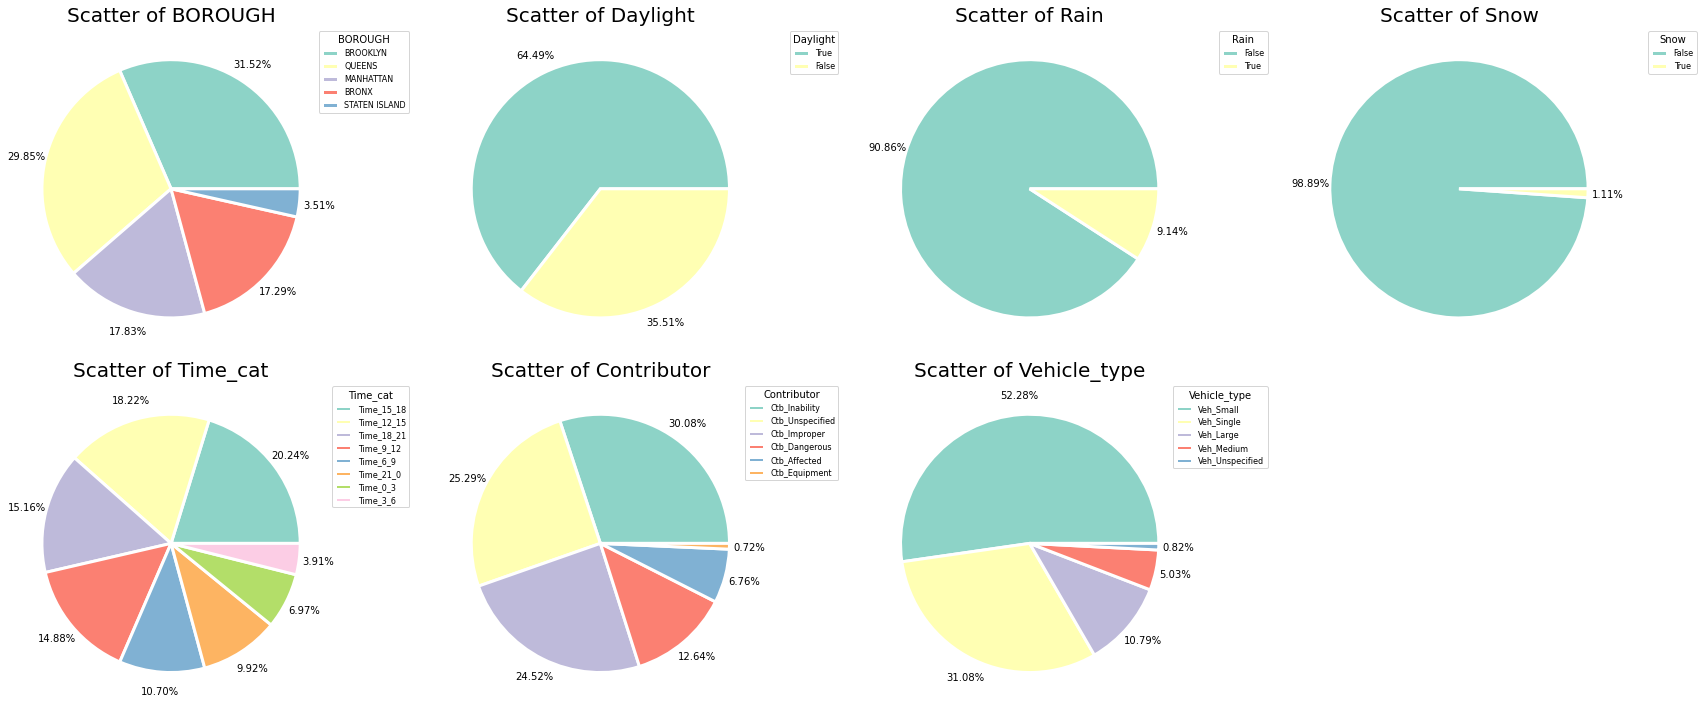

In [15]:
# Categorical data
fig, axes = plt.subplots(2, 4, figsize=[24,10])
axes = axes.flatten()
for i in range(7):
    scatter = accident_df[categorical[i]].value_counts()
    wedges, texts, autotexts = axes[i].pie(scatter.values, colors=colors, autopct=f'%.2f%%', textprops=dict(fontsize=10), pctdistance=1.15, wedgeprops = { 'linewidth' : 3, 'edgecolor' : 'white' })
    axes[i].set_title(f'Scatter of {categorical[i]}', fontsize=20)
    axes[i].legend(wedges, scatter.index.values,
              title=categorical[i],
              bbox_to_anchor=(0.75, 0, 0.5, 1), fontsize=8)
fig.delaxes(axes[7])
plt.tight_layout()
plt.show()


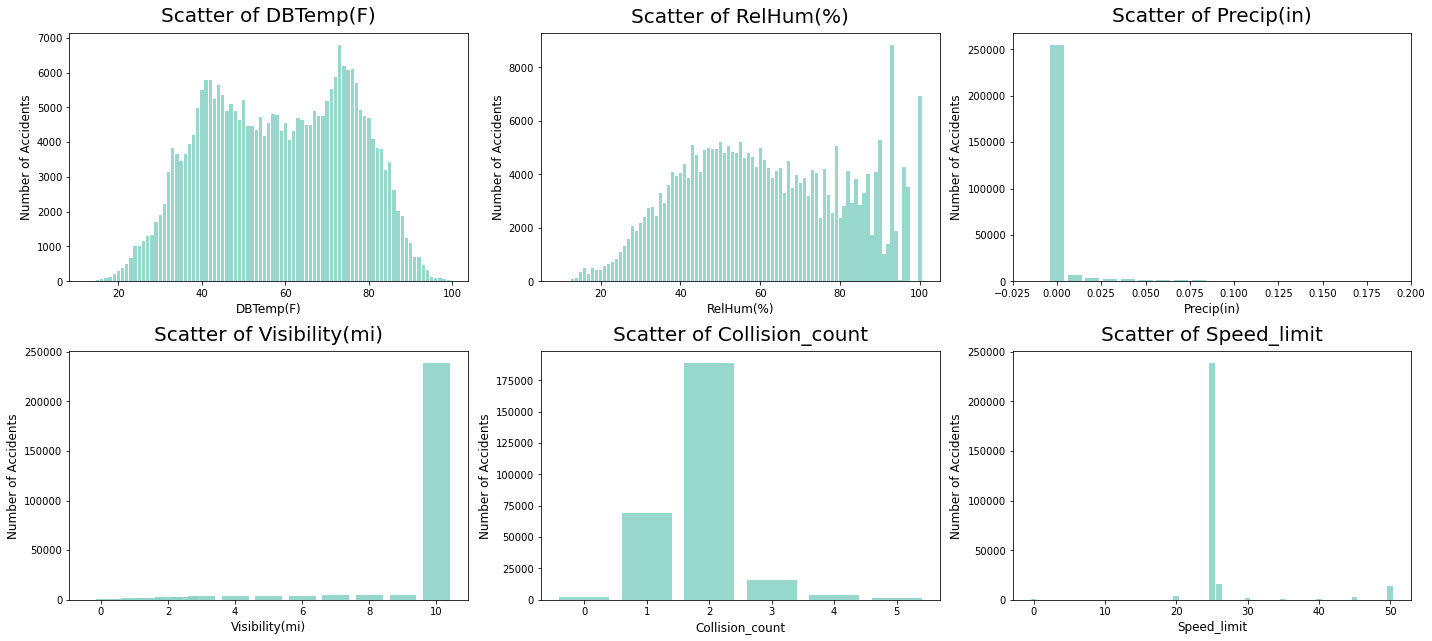

In [16]:
# Numerical data
fig, axes = plt.subplots(2, 3, figsize=[20,9])
axes = axes.flatten()
for i in range(6):
    scatter = accident_df[numerical[i]].value_counts().sort_index()
    if i == 2:
        scatter = scatter[scatter.index < 0.5]
        axes[i].bar(scatter.index, scatter.values, color='#8dd3c7', width=0.008, alpha=0.9)
        axes[i].set_xlim(-0.025, 0.2)
    else:
        axes[i].bar(scatter.index, scatter.values, color='#8dd3c7', alpha=0.9)
    axes[i].set_xlabel(f'{numerical[i]}', fontsize=12)
    axes[i].set_ylabel('Number of Accidents', fontsize=12)
    axes[i].set_title(f'Scatter of {numerical[i]}', y=1.02, fontsize=20)

plt.tight_layout()
plt.show()

### 2-2-7 Change into one-hot encoding

In [17]:
# Rain, Daylight, Snow
weather = ['Rain', 'Daylight', 'Snow']
for w in weather:
    filter1 = accident_df[w] == True
    filter2 = accident_df[w] == False
    accident_df[w][filter1] = 1
    accident_df[w][filter2] = 0

In [18]:
# Process categorical predictors
categories = ['BOROUGH',
             'Time_cat',
             'Contributor',
             'Vehicle_type']

# One-hot encode on categories variables
for cate in categories:
    accident_df = pd.concat([accident_df, pd.get_dummies(accident_df[cate])], axis=1)
    
# Drop columns for description
to_drop = ['BRONX', 'Time_3_6', 'Ctb_Unspecified', 'Veh_Unspecified']
accident_df = accident_df.drop(columns=to_drop)

## 2-3. Responsor Process

In [19]:
# Assign all possible response value to y_accident
y_accident = accident[['NUMBER OF PERSONS INJURED', 
                        'NUMBER OF PERSONS KILLED',
                        'NUMBER OF PEDESTRIANS INJURED', 
                        'NUMBER OF PEDESTRIANS KILLED', 
                        'NUMBER OF CYCLIST INJURED', 
                        'NUMBER OF CYCLIST KILLED', 
                        'NUMBER OF MOTORIST INJURED', 
                        'NUMBER OF MOTORIST KILLED']]

# Classification on Fatality: non-killed 0, injured or killed 1
filter1 = y_accident['NUMBER OF PERSONS INJURED'] > 0
filter2 = y_accident['NUMBER OF PERSONS KILLED'] > 0
y_accident['Casualty'] = np.zeros(y_accident.shape[0])
y_accident['Casualty'][filter1 | filter2] = 1

# Add new grouped value to original dataset
accident_df['Casualty'] = y_accident['Casualty']

# Response col
response = []
if 'Casualty' not in response:
    response.append('Casualty')

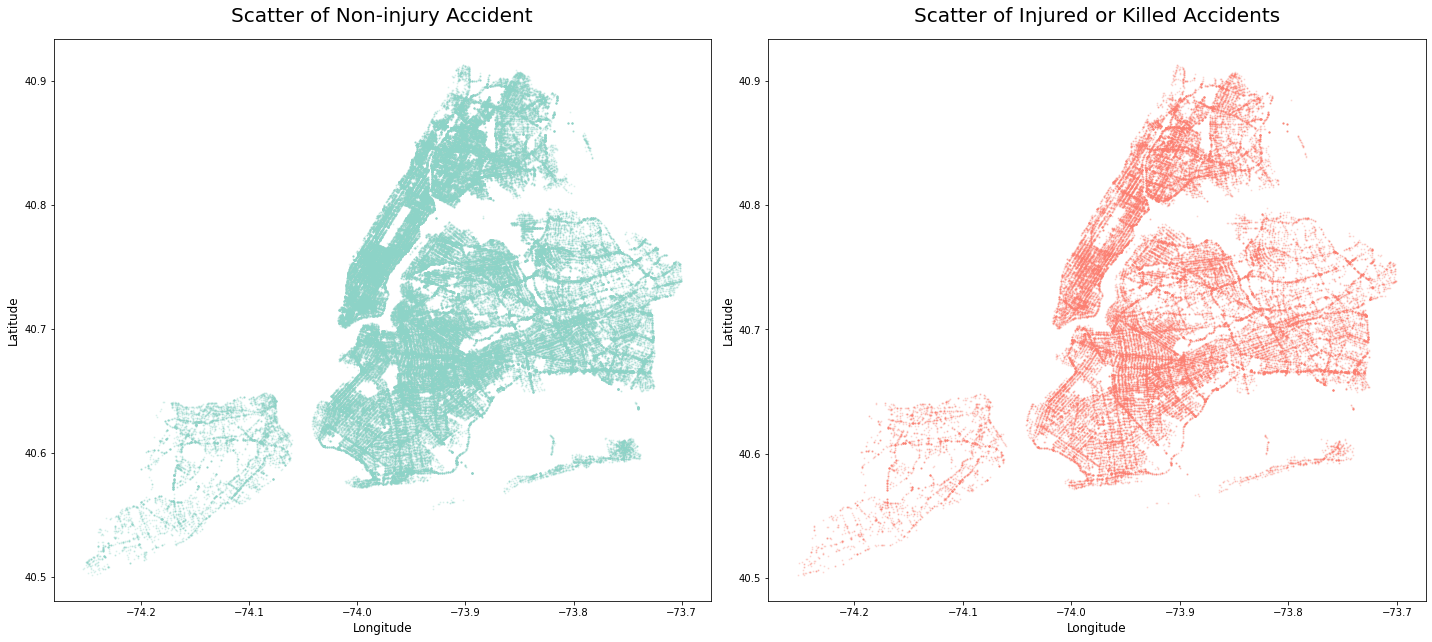

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=[20,9])
ax1.scatter(accident['Longitude'][~filter1 & ~filter2], accident['Latitude'][~filter1 & ~filter2], color='#8dd3c7', s=1, alpha=0.2)
ax2.scatter(accident['Longitude'][filter1 | filter2], accident['Latitude'][filter1 | filter2], color='#fb8072', s=1, alpha=0.2)
ax1.set_xlabel('Longitude', fontsize=12)
ax1.set_ylabel('Latitude', fontsize=12)
ax2.set_xlabel('Longitude', fontsize=12)
ax2.set_ylabel('Latitude', fontsize=12)
ax1.set_title('Scatter of Non-injury Accident', y=1.02, fontsize=20)
ax2.set_title('Scatter of Injured or Killed Accidents', y =1.02, fontsize=20)
plt.tight_layout()
plt.show()

## 2-4. Predictor-Responor Relation

### 2-4-1. Kdeplot

In [21]:
re_process = ['BOROUGH', 'Time_cat', 'Contributor', 'Vehicle_type']
cat = {
    'BOROUGH': {
        'STATEN ISLAND': 1, 'BROOKLYN': 2, 'BRONX': 3, 'QUEENS': 4, 'MANHATTAN': 5
    },
    'Time_cat':{
        'Time_0_3': 1, 'Time_3_6': 2, 'Time_6_9': 3, 'Time_9_12': 4, 'Time_12_15': 5, 
        'Time_15_18': 6, 'Time_18_21': 7, 'Time_21_0': 8
    },
    'Contributor': {
        'Ctb_Inability': 1, 'Ctb_Affected': 2, 'Ctb_Improper': 3, 'Ctb_Unspecified': 4,
       'Ctb_Dangerous': 5, 'Ctb_Equipment': 6
    },
    'Vehicle_type': {
        'Veh_Large': 1, 'Veh_Small': 2, 'Veh_Single': 3, 'Veh_Medium': 4, 'Veh_Unspecified': 5
    }
}
for re in re_process:
    accident_df[f'{re}_re'] = accident_df[re].replace(cat[re])

categorical_processed = ['BOROUGH_re', 'Time_cat_re', 'Contributor_re', 'Vehicle_type_re', 'Daylight', 'Rain', 'Snow']

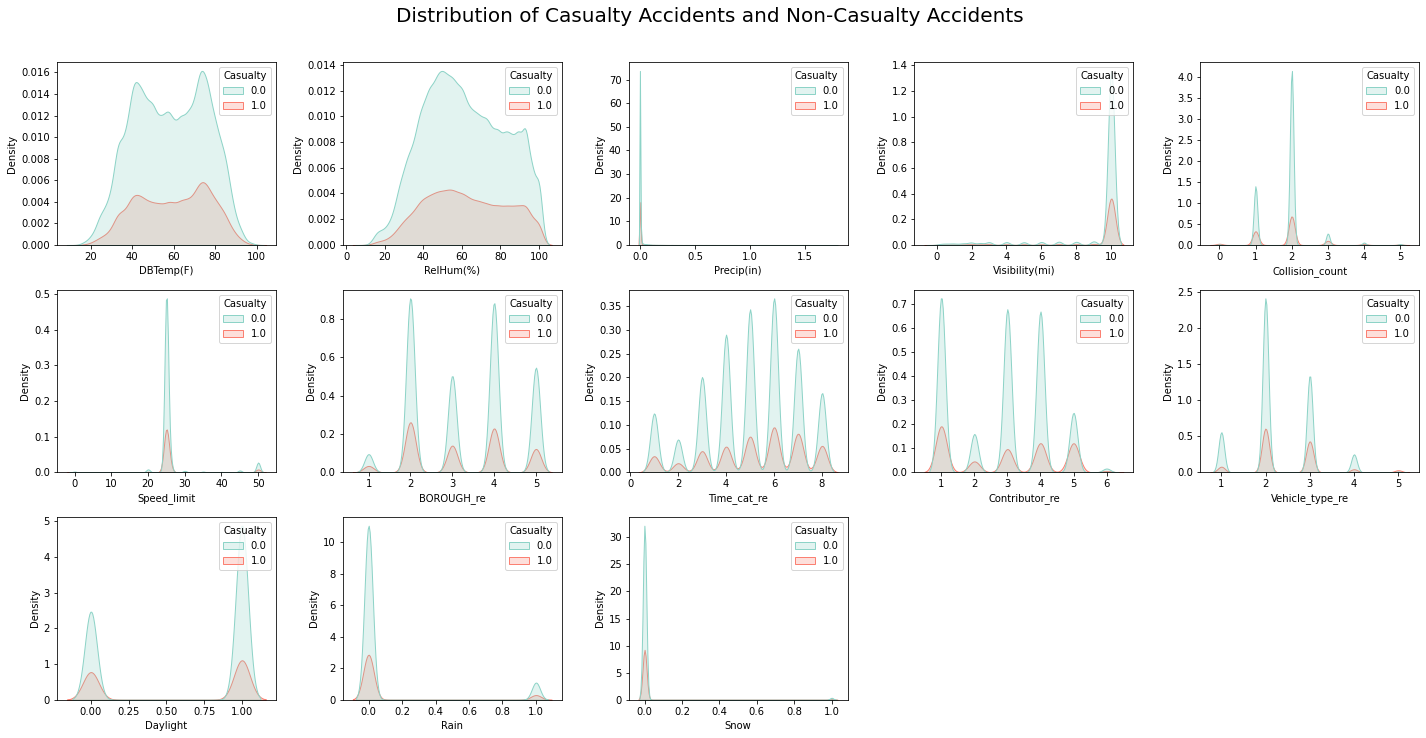

In [22]:
fig, axes = plt.subplots(3,5, figsize=[20, 10])
axes = axes.flatten()
predictors = numerical + categorical_processed

for i, p in enumerate(predictors): 
    if p[:-3] in categorical_processed:
        axes[i].set_xtickslabel(cat[p[:-3]].keys())
    sns.kdeplot(data=accident_df[[p, 'Casualty']], x=p, hue='Casualty', palette=['#8dd3c7', '#fb8072'], ax=axes[i], fill=True)
    
for i in range(13, 15):
    fig.delaxes(axes[i])

plt.suptitle("Distribution of Casualty Accidents and Non-Casualty Accidents", y=1.02, fontsize=20)
plt.tight_layout()
plt.show()

In [23]:
accident_df = accident_df.drop(columns=categorical_processed[:4])

### 2-4-2. Barplot of density

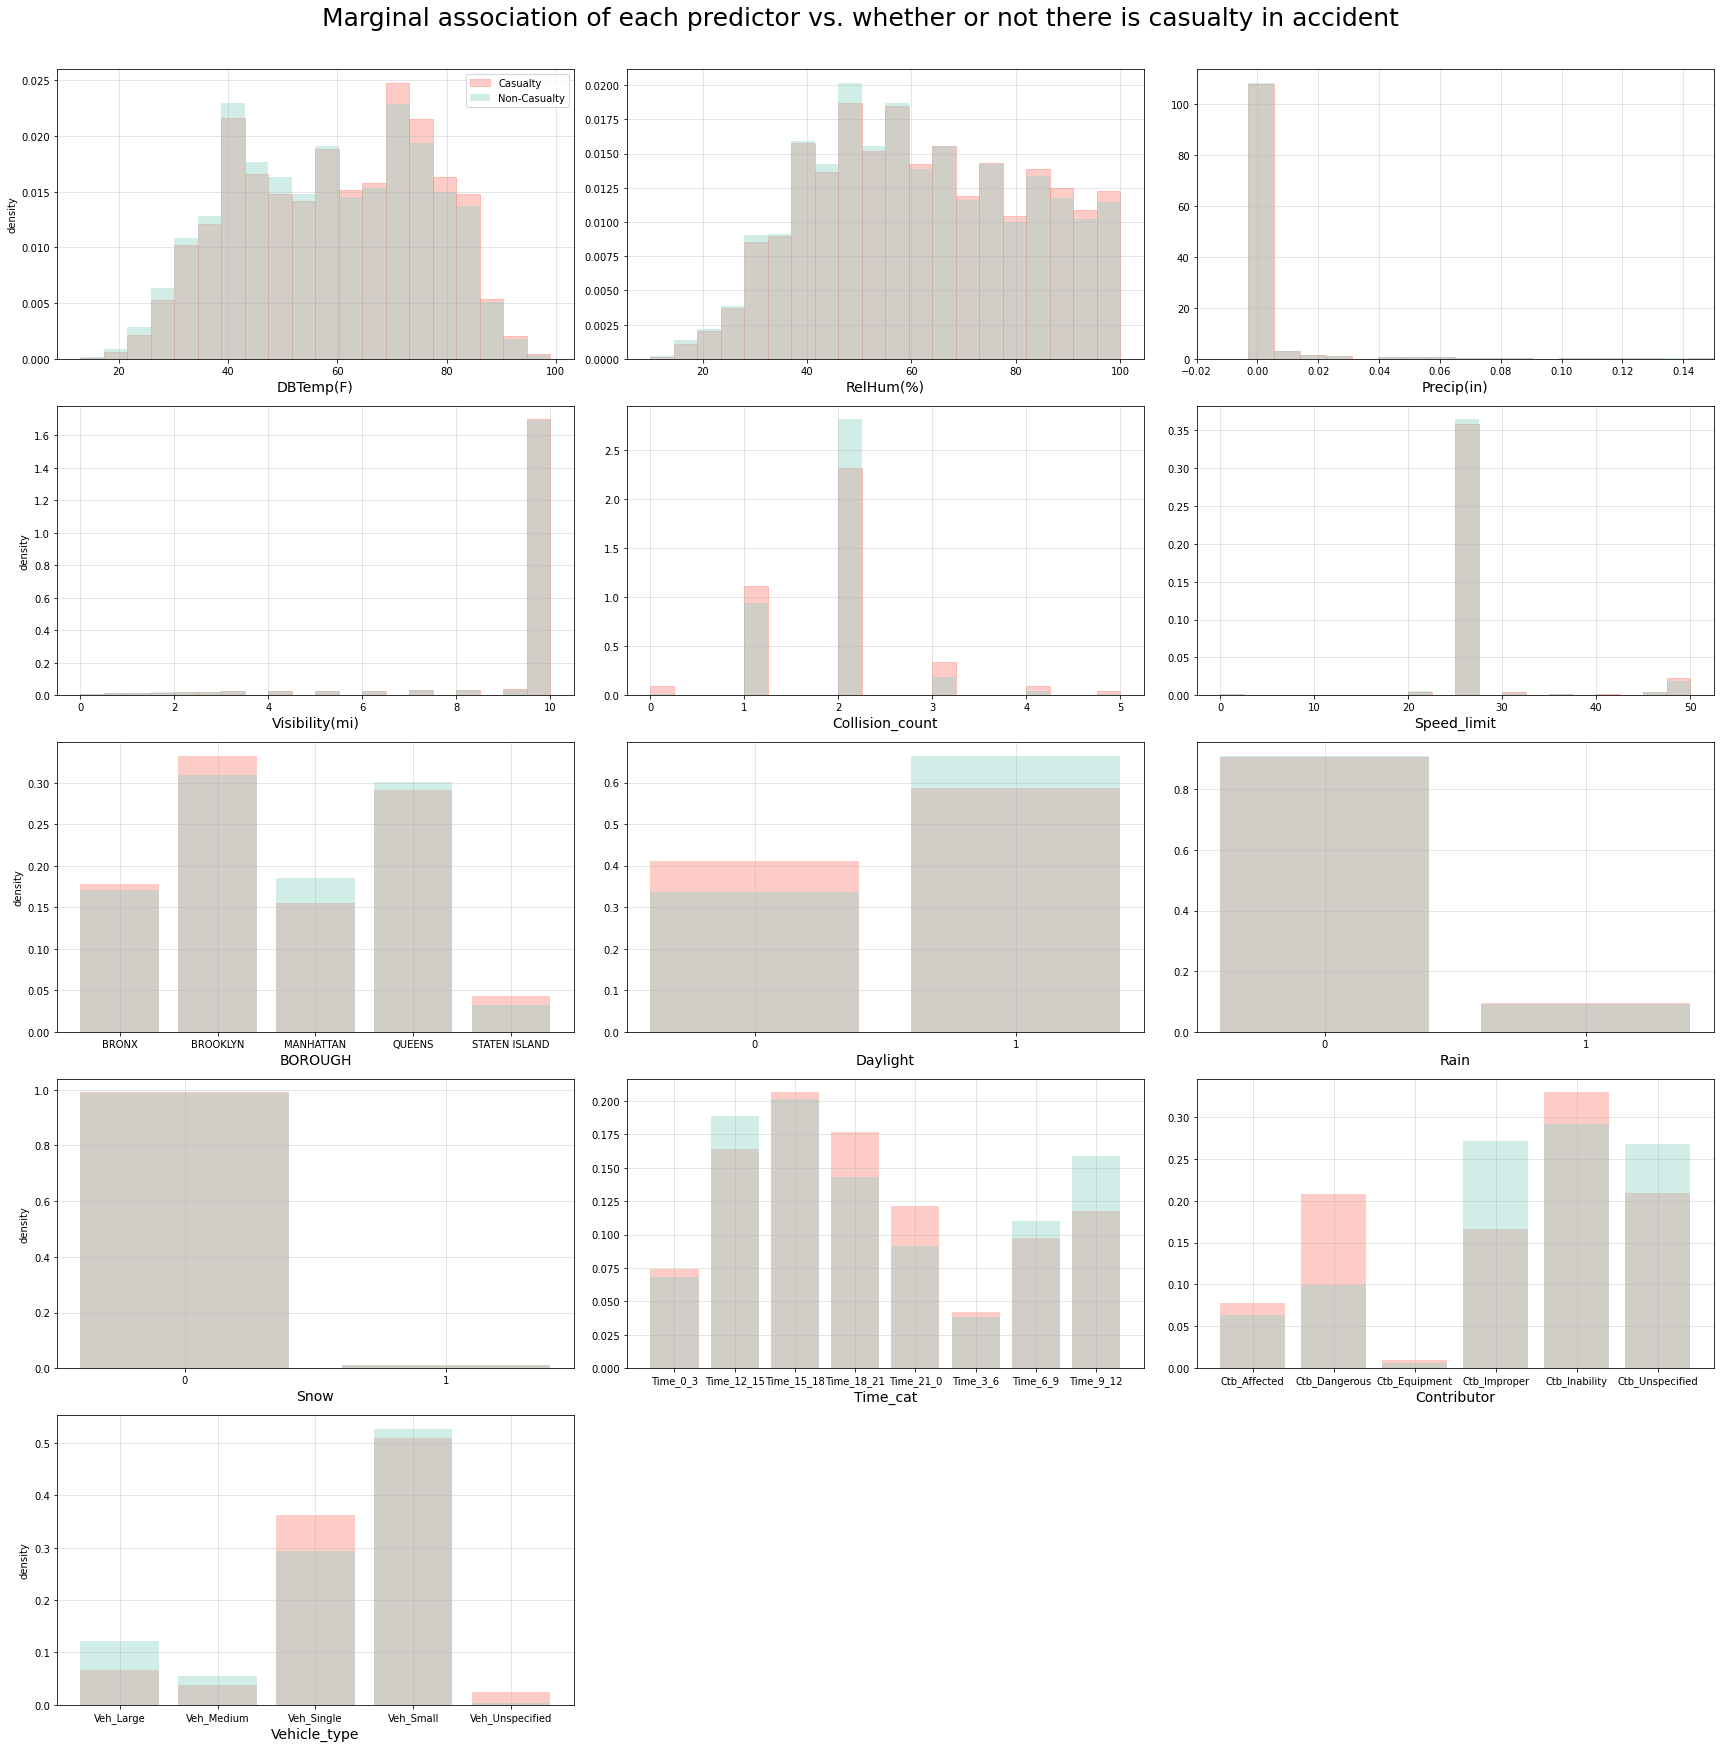

In [24]:
filter1 = accident_df['Casualty'] == 1
predictors = numerical + categorical

# Calculate the number of casualty and non-casualty cases
n_casualty = np.sum(1 * filter1)
n_noncasualty = accident_df.shape[0] - n_casualty

fig, axes = plt.subplots(5,3, figsize=[24, 24])
axes = axes.flatten()
for i, p in enumerate(predictors):
    if p in numerical:
        if i == 2:
            x_min = -0.02
            x_max = 0.15
            axes[i].set_xlim(x_min, x_max)
        else:
            x_min = accident_df[p].min()
            x_max = accident_df[p].max()
        axes[i].hist(accident_df[p][filter1], bins=20, density=True, range=(x_min, x_max), color='#fb8072', edgecolor='#fb8072', alpha=0.4, label='Casualty')
        axes[i].hist(accident_df[p][~filter1], bins=20, density=True, range=(x_min, x_max), color='#8dd3c7', alpha=0.4, label='Non-Casualty')
            
    else:
        pred_count_casualty = accident_df[p][filter1].value_counts().sort_index()
        pred_count_noncasualty = accident_df[p][~filter1].value_counts().sort_index()
        pred_val_casualty = pred_count_casualty.index
        pred_val_noncasualty = pred_count_noncasualty.index
        axes[i].bar(pred_val_casualty, pred_count_casualty / n_casualty, color='#fb8072', alpha=0.4, label='Casualty')
        axes[i].bar(pred_val_noncasualty, pred_count_noncasualty / n_noncasualty, color='#8dd3c7', alpha=0.4, label='Non-Casualty')
        axes[i].set_xticks(pred_val_casualty)
    axes[i].set_xlabel(p, fontsize=14)
    axes[i].set_ylabel('density' if i%3==0 else None)
    axes[i].grid(":", alpha=0.4)
    if i==0:
        axes[i].legend()
    
for i in range(13, 15):
    fig.delaxes(axes[i])
    
plt.suptitle('Marginal association of each predictor vs. whether or not there is casualty in accident', y=1.01, fontsize=25)
plt.tight_layout()
plt.show()

### 2-4-3. Correlation of numerical predictors

In [25]:
accident_df[numerical + categorical + response].corr()

DBTemp(F)  RelHum(%)  Precip(in)  Visibility(mi)  \
DBTemp(F)         1.000000  -0.026158   -0.008243        0.143200   
RelHum(%)        -0.026158   1.000000    0.235112       -0.528265   
Precip(in)       -0.008243   0.235112    1.000000       -0.395335   
Visibility(mi)    0.143200  -0.528265   -0.395335        1.000000   
Collision_count   0.016955  -0.009880   -0.013312        0.018765   
Speed_limit      -0.008090   0.009877    0.001367       -0.000973   
Casualty          0.031834   0.016490    0.003062        0.000835   

                 Collision_count  Speed_limit  Casualty  
DBTemp(F)               0.016955    -0.008090  0.031834  
RelHum(%)              -0.009880     0.009877  0.016490  
Precip(in)             -0.013312     0.001367  0.003062  
Visibility(mi)          0.018765    -0.000973  0.000835  
Collision_count         1.000000     0.073221 -0.003097  
Speed_limit             0.073221     1.000000  0.022032  
Casualty               -0.003097     0.022032  1.000000

## 2-5. Standardization For Model

In [26]:
# apply standardizing to original dataset
accident_df[numerical] = StandardScaler().fit(accident_df[numerical]).transform(accident_df[numerical])

### 2-5-1. Final output for model data

In [27]:
accident_df.drop(columns=categories).to_csv('./data/nyc_accident.csv', index=False)

# 3. Model Training

In [2]:
accident_df = pd.read_csv("./data/nyc_accident.csv")
display(accident_df.head())

Daylight  Rain  Snow  DBTemp(F)  RelHum(%)  Precip(in)  Visibility(mi)  \
0         0     0     0  -1.598603  -1.295350   -0.161364        0.367400   
1         1     0     0  -1.772925   1.241783   -0.161364       -2.396223   
2         1     0     0  -1.772925   1.241783   -0.161364       -2.396223   
3         1     0     0  -1.714817   1.192992   -0.161364       -1.014411   
4         1     0     0  -1.656710   1.144201   -0.161364       -1.935619   

   ZIP CODE  Collision_count  Speed_limit  ...  Ctb_Affected  Ctb_Dangerous  \
0   10307.0        -1.307846    -0.238260  ...             0              0   
1   10309.0        -1.307846     3.839631  ...             1              0   
2   10312.0         0.258177     0.577318  ...             0              0   
3   10312.0        -1.307846     0.577318  ...             0              0   
4   10314.0         0.258177     0.577318  ...             0              1   

   Ctb_Equipment  Ctb_Improper  Ctb_Inability  Veh_Large  Veh_Medium  \
0              0             0              1          1           0   
1              0             0              0          0           0   
2              0             1              0          0           0   
3              0             0              0          0           0   
4              0             0              0          0           0   

   Veh_Single  Veh_Small  Casualty  
0           0          0       0.0  
1           0          1       0.0  
2           0          1       0.0  
3           1          0       0.0  
4           1          0       0.0  

[5 rows x 31 columns]

In [3]:
y = accident_df['Casualty'].values
X = accident_df.drop(['Casualty'], axis=1)
display(X.describe())

Daylight           Rain           Snow     DBTemp(F)  \
count  280787.000000  280787.000000  280787.000000  2.807870e+05   
mean        0.644948       0.091407       0.011076 -1.068900e-16   
std         0.478530       0.288188       0.104658  1.000002e+00   
min         0.000000       0.000000       0.000000 -2.644534e+00   
25%         0.000000       0.000000       0.000000 -8.432081e-01   
50%         1.000000       0.000000       0.000000  2.840104e-02   
75%         1.000000       0.000000       0.000000  8.419029e-01   
max         1.000000       1.000000       1.000000  2.352692e+00   

          RelHum(%)    Precip(in)  Visibility(mi)       ZIP CODE  \
count  2.807870e+05  2.807870e+05    2.807870e+05  280787.000000   
mean  -1.774415e-16  7.895285e-18    3.469876e-16   10888.870742   
std    1.000002e+00  1.000002e+00    1.000002e+00     532.273329   
min   -2.515125e+00 -1.613637e-01   -4.238639e+00   10000.000000   
25%   -7.586488e-01 -1.613637e-01    3.674005e-01   10454.000000   
50%   -7.557465e-02 -1.613637e-01    3.674005e-01   11208.000000   
75%    8.514545e-01 -1.613637e-01    3.674005e-01   11355.000000   
max    1.876066e+00  4.399088e+01    3.674005e-01   11697.000000   

       Collision_count   Speed_limit  ...      Time_9_12  Ctb_Affected  \
count     2.807870e+05  2.807870e+05  ...  280787.000000  280787.00000   
mean      1.893856e-16 -1.819458e-16  ...       0.148839       0.06756   
std       1.000002e+00  1.000002e+00  ...       0.355930       0.25099   
min      -2.873870e+00 -4.316152e+00  ...       0.000000       0.00000   
25%      -1.307846e+00 -2.382604e-01  ...       0.000000       0.00000   
50%       2.581772e-01 -2.382604e-01  ...       0.000000       0.00000   
75%       2.581772e-01 -2.382604e-01  ...       0.000000       0.00000   
max       4.956248e+00  3.839631e+00  ...       1.000000       1.00000   

       Ctb_Dangerous  Ctb_Equipment   Ctb_Improper  Ctb_Inability  \
count  280787.000000  280787.000000  280787.000000  280787.000000   
mean        0.126352       0.007158       0.245232       0.300833   
std         0.332246       0.084304       0.430226       0.458621   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   

           Veh_Large     Veh_Medium     Veh_Single      Veh_Small  
count  280787.000000  280787.000000  280787.000000  280787.000000  
mean        0.107882       0.050316       0.310837       0.522784  
std         0.310232       0.218596       0.462837       0.499482  
min         0.000000       0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000       1.000000  
75%         0.000000       0.000000       1.000000       1.000000  
max         1.000000       1.000000       1.000000       1.000000  

[8 rows x 30 columns]

In [4]:
random_state = 74

# Split train test set
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=random_state)
print('X_train.shape',X_train.shape)
print('y_train.shape',y_train.shape)
print('X_test.shape',X_test.shape)
print('y_test.shape',y_test.shape)

X_train.shape (224629, 30)
y_train.shape (224629,)
X_test.shape (56158, 30)
y_test.shape (56158,)


## 3-1. Logistical Regression

In [5]:
# Dictionaries to store all the performance metrics of all the models
all_accuarcy = {}
all_f1 = {}
all_precision_recall = {}
all_calc_fpr_fnr = {}
all_roc = {}

In [6]:
# Helper functions

# functions to plot the performance metrics
def plot_metrics(precision,recall,fpr,tpr,th_pos,fnr,th_neg,label):
    # Plot Precision Recall
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title("Precision Recall in Training Observations")
    plt.show()
    
    # Plot ROC curve
    x=np.arange(0,100)/100
    plt.plot(x,x,'--',color="gray",alpha=0.3)
    plt.plot(fpr,tpr,label="train")
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title("ROC Curve for Predicting Casualty in a Simple Logistic Regression Model")
    plt.show()
    
    plt.plot(th_neg,fnr)
    plt.xlabel("Threshold")
    plt.ylabel("False Negative Rate")
    plt.title("FNR vs. Thresholds for Predicting Casualty")
    plt.show()
    
    plt.plot(th_pos,fpr)
    plt.xlabel("Threshold")
    plt.ylabel("False Positive Rate")
    plt.title("FPR vs. Thresholds for Predicting Casualty")
    plt.show()

# functions to get the different performance metrics
def bundle_performance_metric(y_true,y_pred, y_pred_proba,lable,model):
    accuarcy = accuracy_score(y_true,y_pred)
    f1 = f1_score(y_true,y_pred,average='weighted')
    precision, recall, _ = precision_recall_curve(y_true,y_pred_proba)
    
    tn, fn, fp, tp = confusion_matrix(y_true, y_pred).ravel()
    calculated_fpr = fp / (fp + tn)
    calculated_fnr = fn / (fn + tp)
    
    fpr, tpr, th_pos = roc_curve(y_true, y_pred_proba)
    fnr, tnr, th_neg = roc_curve(y_true, y_pred_proba,pos_label=0)
    
    # add performance scores to dictionary
    if lable == 'train':
        all_accuarcy[model] = accuarcy
        all_f1[model] = f1
        all_precision_recall[model] = [precision,recall]
        all_calc_fpr_fnr[model] = [calculated_fpr,calculated_fnr]
        all_roc[model] = [fpr,fnr,th_pos]
    
    print(f'The performance metrics for {lable} are:')
    print(f'Prediction accuracies: {accuarcy}')
    print(f'f1 score: {f1}')
    print(f'Calculated false positive rate: {calculated_fpr}')
    print(f'Calculated false negative rate: {calculated_fnr}')
    plot_metrics(precision,recall,fpr,tpr,th_pos,fnr,th_neg,lable)
    positives = [fpr,tpr,th_pos]
    negatives = [fnr,tnr,th_neg]
    return positives, negatives

### 3-1-1. Simple Logistic Regression

In [7]:
# Create Model and Fit to entire data set
base_logit= LogisticRegression(penalty='none').fit(X_train, y_train)

# Model intercept and coefs
intercept = base_logit.intercept_
coefs = base_logit.coef_
print(f'model intercept: {intercept}')
for i, v in enumerate(X_train.columns):
    print(f'{v} : {coefs[0][i]:.4f}')
    
# Check for unimportant variables
important = list(np.array(X_train.columns)[coefs[0] !=0])
unimportant = list(np.array(X_train.columns)[coefs[0] ==0])

print("These variables were important", important)
print("\nThese variables were unimportant", unimportant)

model intercept: [-0.01774968]
Daylight : -0.2967
Rain : 0.0052
Snow : -0.0045
DBTemp(F) : 0.1385
RelHum(%) : 0.0024
Precip(in) : -0.0344
Visibility(mi) : 0.0601
ZIP CODE : -0.0001
Collision_count : 0.0161
Speed_limit : 0.0638
BROOKLYN : 0.1267
MANHATTAN : -0.1908
QUEENS : 0.0064
STATEN ISLAND : 0.0373
Time_0_3 : 0.0042
Time_12_15 : -0.0871
Time_15_18 : 0.0325
Time_18_21 : 0.1265
Time_21_0 : 0.1152
Time_6_9 : -0.0489
Time_9_12 : -0.1687
Ctb_Affected : 0.0591
Ctb_Dangerous : 0.5068
Ctb_Equipment : 0.0160
Ctb_Improper : -0.4422
Ctb_Inability : 0.1516
Veh_Large : -0.2536
Veh_Medium : -0.0772
Veh_Single : 0.2470
Veh_Small : -0.0465
These variables were important ['Daylight', 'Rain', 'Snow', 'DBTemp(F)', 'RelHum(%)', 'Precip(in)', 'Visibility(mi)', 'ZIP CODE', 'Collision_count', 'Speed_limit', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND', 'Time_0_3', 'Time_12_15', 'Time_15_18', 'Time_18_21', 'Time_21_0', 'Time_6_9', 'Time_9_12', 'Ctb_Affected', 'Ctb_Dangerous', 'Ctb_Equipment', 'Ctb_I

The performance metrics for train are:
Prediction accuracies: 0.7510828966874268
f1 score: 0.6476060108084223
Calculated false positive rate: 0.2481481812414557
Calculated false negative rate: 0.46540880503144655


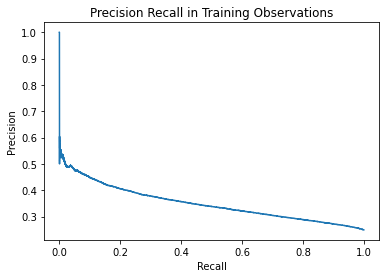

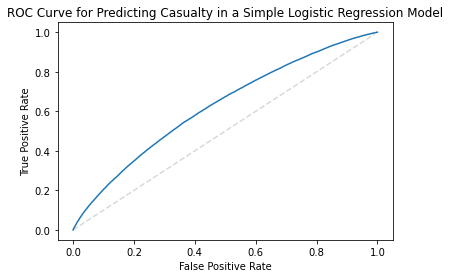

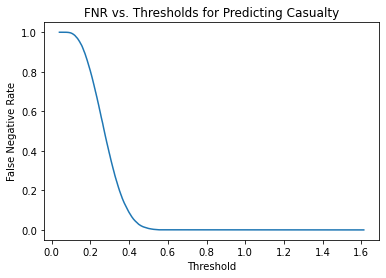

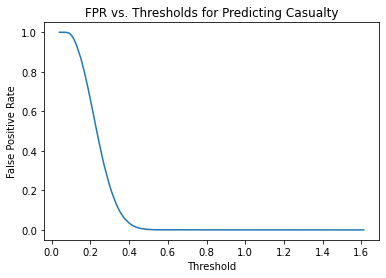

The performance metrics for test are:
Prediction accuracies: 0.7492788204708145
f1 score: 0.645278017912246
Calculated false positive rate: 0.2498212753788962
Calculated false negative rate: 0.49514563106796117


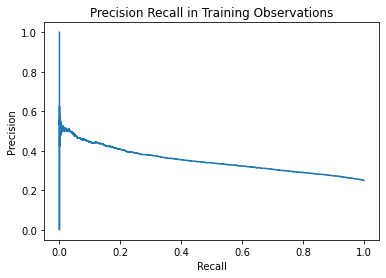

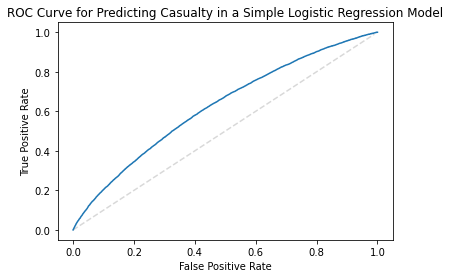

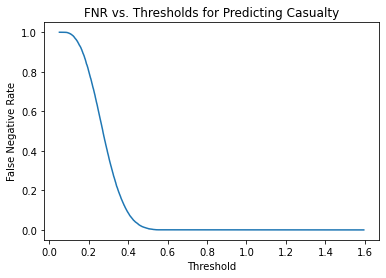

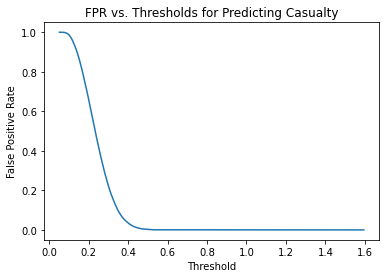

In [8]:
# Prediction
y_pred_train = base_logit.predict(X_train)
y_pred_test = base_logit.predict(X_test)

y_pred_prob_train = base_logit.predict_proba(X_train)[:,1]
y_pred_prob_test = base_logit.predict_proba(X_test)[:,1]

# Call helper functions to see the model performance
train_pos1, train_neg1 = bundle_performance_metric(y_train,y_pred_train,y_pred_prob_train,'train','logit_1')
test_pos1, test_neg1 = bundle_performance_metric(y_test,y_pred_test,y_pred_prob_test,'test','logit_1')

In [9]:
# Helper function to add predicted data to file for later visualization
def append_predict(train,test,train_pred,test_pred,train_pred_prob,test_pred_prob,fname):
    train_copy = train.copy()
    test_copy = test.copy()
    
    train_copy['Casualty'] = y_train
    train_copy['Casualty_Prediction'] = train_pred
    test_copy['Casualty'] = y_test
    test_copy['Casualty_Prediction'] = test_pred
    train_copy['Casualty_Prediction_Probability'] = train_pred_prob
    test_copy['Casualty_Prediction_Probability'] = test_pred_prob
    ftype ='.csv'
    data = [train_copy, test_copy]
    df = pd.concat(data)
    df.to_csv(fname+ftype)
    test_copy.to_csv(fname+'_test'+ftype)
    print('Prediction combined with train and test data is saved at', fname)

### 3-1-2. Logistical Regression with Selected Predictors

##### 3-1-2-1. base line model

In [10]:
# Use predictors showing differences in the distribution graph
predictors = ['Daylight','Collision_count', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND','Daylight',
                    'Time_0_3','Time_12_15', 'Time_15_18', 'Time_18_21', 'Time_21_0', 'Time_6_9','Time_9_12', 
                    'Ctb_Affected', 'Ctb_Dangerous', 'Ctb_Equipment','Ctb_Improper', 'Ctb_Inability', 
                    'Veh_Large', 'Veh_Medium','Veh_Single', 'Veh_Small']

# Create and fit model with interaction terms
logit2 = LogisticRegression(penalty='none', max_iter=1000).fit(X_train[predictors].values, y_train)

# Model coef & intercept 
print(f'model intercept: {logit2.intercept_}')
for i, v in enumerate(X_train[predictors].columns):
    print(f'{v} : {logit2.coef_[0][i]:.4f}')
    
# Check for unimportant variables
important = list(np.array(X_train[predictors].columns)[logit2.coef_[0] !=0])
unimportant = list(np.array(X_train[predictors].columns)[logit2.coef_[0] ==0])

print("These variables were important", important)
print("\nThese variables were unimportant", unimportant)

model intercept: [1.09617503]
Daylight : -0.0712
Collision_count : 0.0702
BROOKLYN : 0.0145
MANHATTAN : -0.1903
QUEENS : -0.1162
STATEN ISLAND : 0.1146
Daylight : -0.0712
Time_0_3 : -0.0203
Time_12_15 : 0.0529
Time_15_18 : 0.1663
Time_18_21 : 0.2255
Time_21_0 : 0.2244
Time_6_9 : 0.0480
Time_9_12 : -0.0856
Ctb_Affected : 0.5019
Ctb_Dangerous : 1.0186
Ctb_Equipment : 0.7050
Ctb_Improper : -0.1416
Ctb_Inability : 0.4331
Veh_Large : -3.0045
Veh_Medium : -2.7591
Veh_Single : -2.2292
Veh_Small : -2.5042
These variables were important ['Daylight', 'Collision_count', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND', 'Daylight', 'Time_0_3', 'Time_12_15', 'Time_15_18', 'Time_18_21', 'Time_21_0', 'Time_6_9', 'Time_9_12', 'Ctb_Affected', 'Ctb_Dangerous', 'Ctb_Equipment', 'Ctb_Improper', 'Ctb_Inability', 'Veh_Large', 'Veh_Medium', 'Veh_Single', 'Veh_Small']

These variables were unimportant []



The performance metrics for train are:
Prediction accuracies: 0.7549960156524759
f1 score: 0.666239079089516
Calculated false positive rate: 0.2421493117173707
Calculated false negative rate: 0.3913448115402513


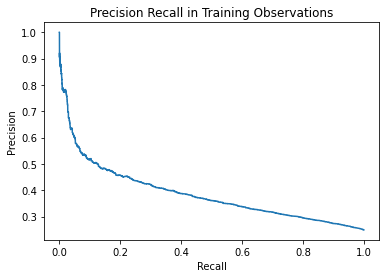

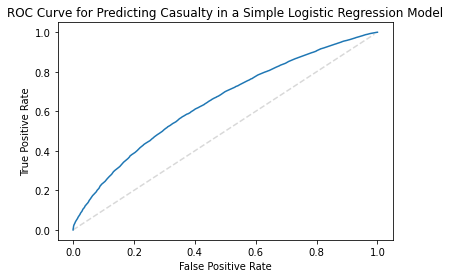

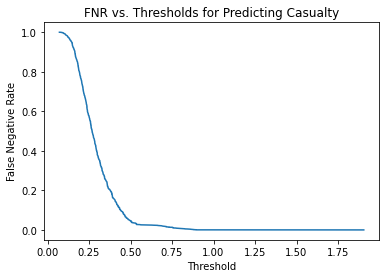

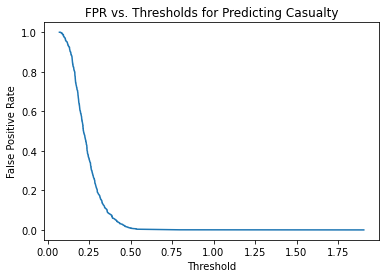

The performance metrics for test are:
Prediction accuracies: 0.753463442430286
f1 score: 0.6637897824030816
Calculated false positive rate: 0.24387145941826496
Calculated false negative rate: 0.3868194842406877


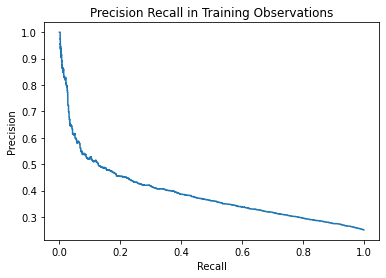

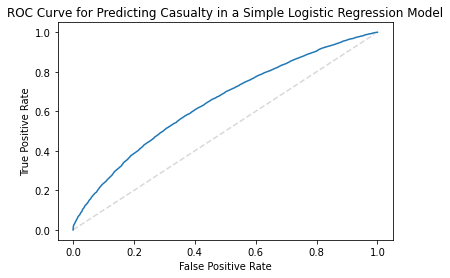

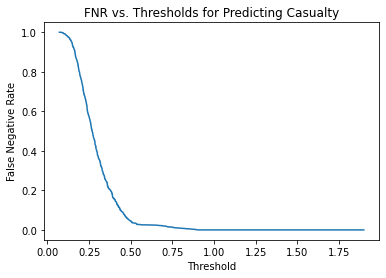

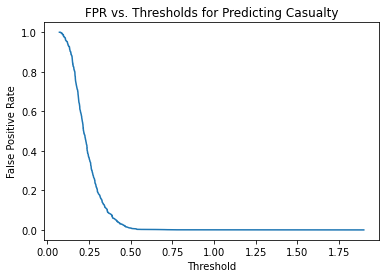

In [11]:
# Predictions
y_pred_train = logit2.predict(X_train[predictors])
y_pred_test = logit2.predict(X_test[predictors])
y_pred_proba_train = logit2.predict_proba(X_train[predictors])[:,1]
y_pred_proba_test = logit2.predict_proba(X_test[predictors])[:,1]
print('')

# Get model performance metrics
train_pos, train_neg = bundle_performance_metric(y_train,y_pred_train,y_pred_proba_train,'train','logit_2_1')
test_pos, test_neg = bundle_performance_metric(y_test,y_pred_test,y_pred_proba_test,'test','logit_2_1')

##### 3-1-2-2. Improved model with predictions above selected threshold

In [12]:
# Helper function to find the best threshold depending on the FPR & FNR
def findBestThreshold(pos_rates, neg_rates, thresholds,ideal_rate):
    best_threshold = None
    best_index = None
    for i in range(len(pos_rates)):
        # find the first threshold where both FPR & FNR are smaller or equal to the ideal rate
        if((round(pos_rates[i],3)<=ideal_rate) & (round(neg_rates[i],3)<=ideal_rate)):
            best_threshold = thresholds[i]
            best_index = i
            break
    return best_threshold,best_index

In [13]:
# Find the best threshold for achieving best fnr and fpr
ideal_rate = 0.01

best_threshold_train, best_ind_train = findBestThreshold(np.flip(train_pos[0]),np.flip(train_neg[0]),np.flip(train_neg[2]),ideal_rate)
print(f'To achieve {ideal_rate} in false positive rate and false negative rate')
print(f'The best threshold is {best_threshold_train}')

To achieve 0.01 in false positive rate and false negative rate
The best threshold is 0.7571699881685234


In [14]:
# Helper function to predict data with 
def predict_with_threshold(y_pred_prob,threshold):
    prediction = []
    for i in range (len(y_pred_prob)):
        if y_pred_prob[i] >= threshold:
            prediction.append(1)
        else:
            prediction.append(0)
    return prediction

The performance metrics for train are:
Prediction accuracies: 0.7526410214175374
f1 score: 0.6494973809348389
Calculated false positive rate: 0.24745435706884847
Calculated false negative rate: 0.2175732217573222


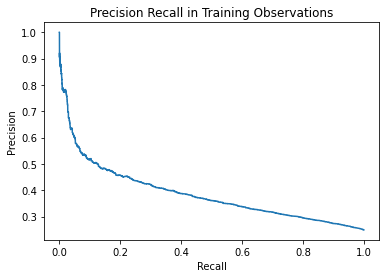

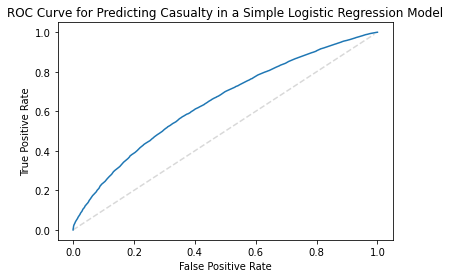

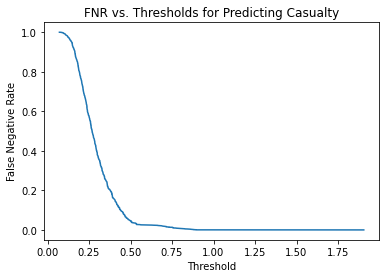

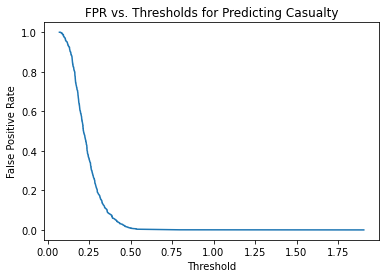

The performance metrics for test are:
Prediction accuracies: 0.7515402970191246
f1 score: 0.6480755424594505
Calculated false positive rate: 0.2487986137163478
Calculated false negative rate: 0.143646408839779


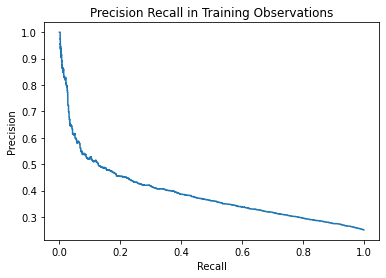

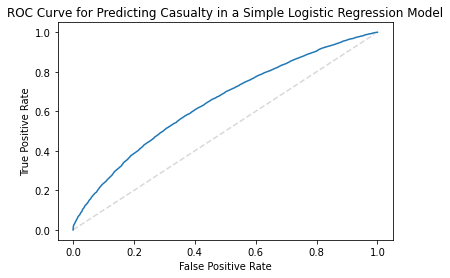

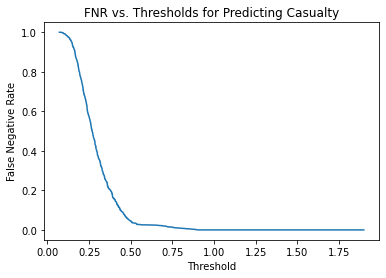

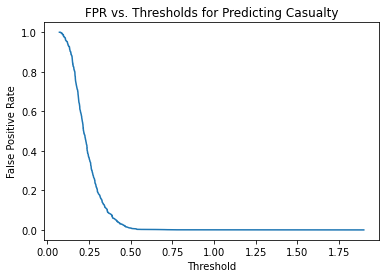

In [15]:
y_pred_th_train = predict_with_threshold(y_pred_proba_train,best_threshold_train)
y_pred_th_test = predict_with_threshold(y_pred_proba_test,best_threshold_train)

# Get model performance metrics
_,_ = bundle_performance_metric(y_train,y_pred_th_train,y_pred_proba_train,'train','logit_2_2')
_,_ = bundle_performance_metric(y_test,y_pred_th_test,y_pred_proba_test,'test','logit_2_2')

### 3-1-3. Logistic Regression using Selected Predictors with Interaction

#### 3-1-3-1. Baseline

In [16]:
# Looking at interaction between Ctb_Dangerous and Veh_Single
X_train3 = X_train.copy()
X_test3 = X_test.copy()
X_train3['Ctb_Dangerous_Daylight'] = X_train['Ctb_Dangerous'] * X_train['Daylight']
X_test3['Ctb_Dangerous_Daylight'] = X_test['Ctb_Dangerous'] * X_test['Daylight']
predictors3 = predictors
predictors3.append('Ctb_Dangerous_Daylight')
# Create Logistic Regression Model and fit it
logit3 = LogisticRegression(penalty='none', max_iter=1000).fit(X_train3[predictors3].values, y_train)

# Model coef & intercept 
print(f'model intercept: {logit3.intercept_}')
for i, v in enumerate(X_train3[predictors3].columns):
    print(f'{v} : {logit3.coef_[0][i]:.4f}')
    
# Check for unimportant variables
important = list(np.array(X_train3[predictors3].columns)[logit3.coef_[0] !=0])
unimportant = list(np.array(X_train3[predictors3].columns)[logit3.coef_[0] ==0])

print("These variables were important", important)
print("\nThese variables were unimportant", unimportant)

model intercept: [1.0986322]
Daylight : -0.0733
Collision_count : 0.0703
BROOKLYN : 0.0146
MANHATTAN : -0.1900
QUEENS : -0.1162
STATEN ISLAND : 0.1148
Daylight : -0.0733
Time_0_3 : -0.0196
Time_12_15 : 0.0529
Time_15_18 : 0.1664
Time_18_21 : 0.2253
Time_21_0 : 0.2246
Time_6_9 : 0.0480
Time_9_12 : -0.0855
Ctb_Affected : 0.5018
Ctb_Dangerous : 1.0037
Ctb_Equipment : 0.7074
Ctb_Improper : -0.1413
Ctb_Inability : 0.4332
Veh_Large : -3.0047
Veh_Medium : -2.7598
Veh_Single : -2.2291
Veh_Small : -2.5041
Ctb_Dangerous_Daylight : 0.0261
These variables were important ['Daylight', 'Collision_count', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND', 'Daylight', 'Time_0_3', 'Time_12_15', 'Time_15_18', 'Time_18_21', 'Time_21_0', 'Time_6_9', 'Time_9_12', 'Ctb_Affected', 'Ctb_Dangerous', 'Ctb_Equipment', 'Ctb_Improper', 'Ctb_Inability', 'Veh_Large', 'Veh_Medium', 'Veh_Single', 'Veh_Small', 'Ctb_Dangerous_Daylight']

These variables were unimportant []



The performance metrics for train are:
Prediction accuracies: 0.7550138227922486
f1 score: 0.6653979859289173
Calculated false positive rate: 0.24242781432334287
Calculated false negative rate: 0.3842546890424482


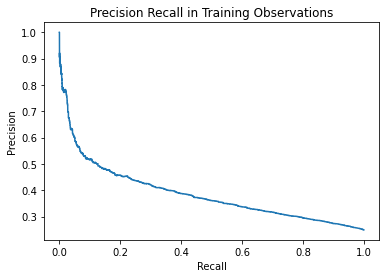

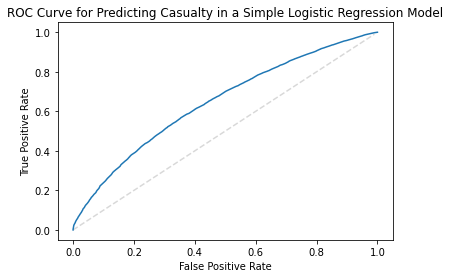

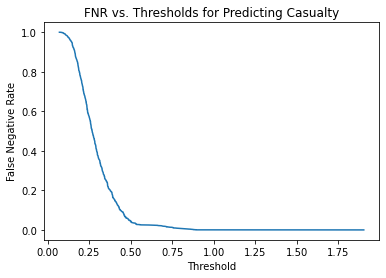

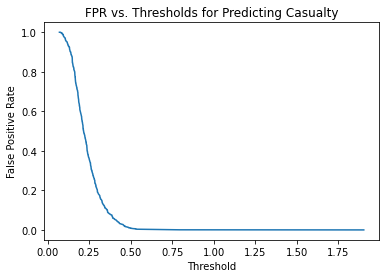

The performance metrics for test are:
Prediction accuracies: 0.7538195804693899
f1 score: 0.6633721390549739
Calculated false positive rate: 0.24398731309469868
Calculated false negative rate: 0.36927772126144454


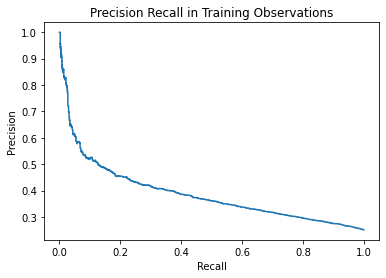

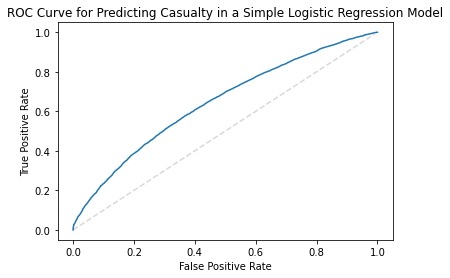

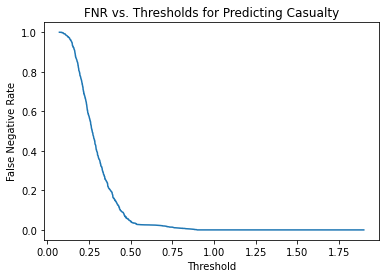

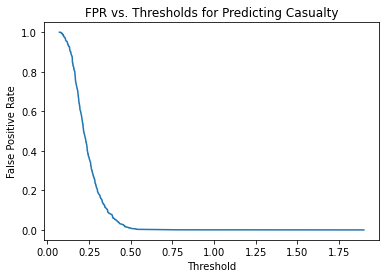

In [17]:
# Predictions
y_pred_train = logit3.predict(X_train3[predictors3])
y_pred_test = logit3.predict(X_test3[predictors3])
y_pred_proba_train = logit3.predict_proba(X_train3[predictors3])[:,1]
y_pred_proba_test = logit3.predict_proba(X_test3[predictors3])[:,1]
print('')

# Get model performance metrics
train_pos, train_neg = bundle_performance_metric(y_train,y_pred_train,y_pred_proba_train,'train','logit_3_1')
test_pos, test_neg = bundle_performance_metric(y_test,y_pred_test,y_pred_proba_test,'test','logit_3_1')

#### 3-1-3-2. Improved model with predictions above selected threshold

In [18]:
ideal_rate = 0.01

best_threshold, best_ind_train = findBestThreshold(np.flip(train_pos[0]),np.flip(train_neg[0]),np.flip(train_neg[2]),ideal_rate)
# best_threshold_test, best_ind_test = findBestThreshold(np.flip(test_pos[0]),np.flip(test_neg[0]),np.flip(test_neg[2]),ideal_rate)
# best_threshold = max(best_threshold_train, best_threshold_test)
print(f'To achieve {ideal_rate} in false positive rate and false negative rate')
print(f'The best threshold is {best_threshold}')

To achieve 0.01 in false positive rate and false negative rate
The best threshold is 0.7576394633651236


The performance metrics for train are:
Prediction accuracies: 0.7526410214175374
f1 score: 0.6494973809348389
Calculated false positive rate: 0.24745435706884847
Calculated false negative rate: 0.2175732217573222


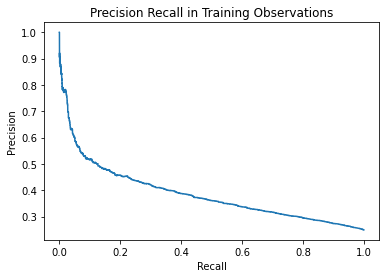

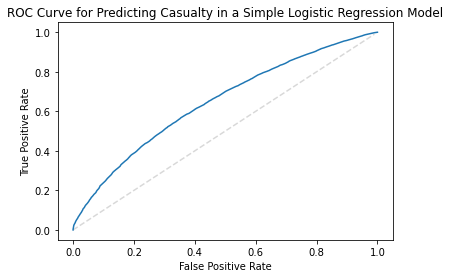

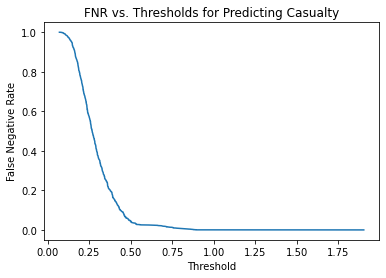

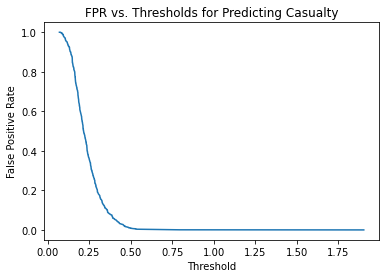

The performance metrics for test are:
Prediction accuracies: 0.7515402970191246
f1 score: 0.6480755424594505
Calculated false positive rate: 0.2487986137163478
Calculated false negative rate: 0.143646408839779


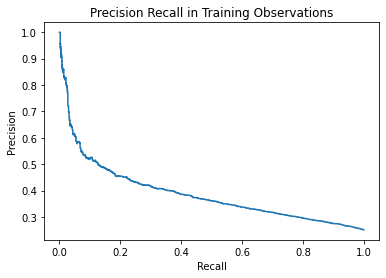

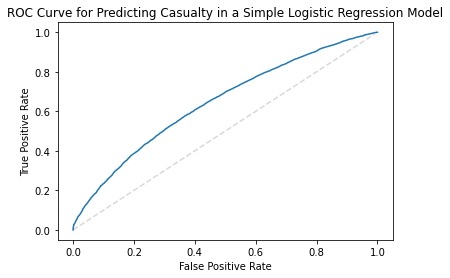

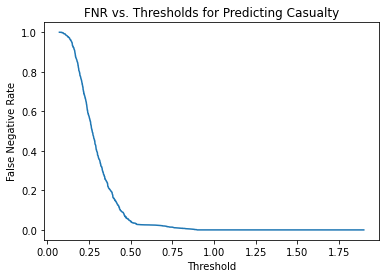

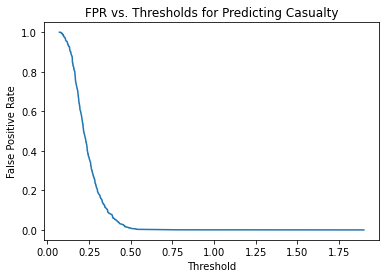

In [19]:
y_pred_th_train = predict_with_threshold(y_pred_proba_train,best_threshold)
y_pred_th_test = predict_with_threshold(y_pred_proba_test,best_threshold)

# Get model performance metrics
_,_ = bundle_performance_metric(y_train,y_pred_th_train,y_pred_proba_train,'train','logit_3_2')
_,_ = bundle_performance_metric(y_test,y_pred_th_test,y_pred_proba_test,'test','logit_3_2')

## 3-2. Lasso

In [49]:
max_iter = 1000
model_lasso = LogisticRegressionCV(fit_intercept=True, cv=10, max_iter=max_iter, scoring='accuracy', solver='liblinear', penalty='l1')
model_lasso.fit(X_train,y_train)

LogisticRegressionCV(cv=10, max_iter=1000, penalty='l1', scoring='accuracy',
                     solver='liblinear')

In [50]:
# Report on coefficient
intercept_base = model_lasso.intercept_
print(f'model intercept: {intercept_base}')
for i, v in enumerate(X_train.columns):
    print(f'{v} : {model_lasso.coef_[0][i]:.4f}')
    
# Check for unimportant variablesO
important = list(np.array(X_train.columns)[model_lasso.coef_[0] !=0])
unimportant = list(np.array(X_train.columns)[model_lasso.coef_[0] ==0])

print("These variables were important", important)
print("\nThese variables were unimportant", unimportant)

model intercept: [0.20342775]
Daylight : -0.2441
Rain : 0.0500
Snow : -0.0310
DBTemp(F) : 0.1063
RelHum(%) : -0.0013
Precip(in) : -0.0059
Visibility(mi) : -0.0032
ZIP CODE : 0.0001
Collision_count : 0.0598
Speed_limit : 0.0615
BROOKLYN : -0.0238
MANHATTAN : -0.1450
QUEENS : -0.1745
STATEN ISLAND : 0.1282
Time_0_3 : -0.0301
Time_12_15 : 0.1113
Time_15_18 : 0.2093
Time_18_21 : 0.2264
Time_21_0 : 0.2055
Time_6_9 : 0.1422
Time_9_12 : -0.0067
Ctb_Affected : 0.4947
Ctb_Dangerous : 1.0262
Ctb_Equipment : 0.6956
Ctb_Improper : -0.1548
Ctb_Inability : 0.4293
Veh_Large : -2.8022
Veh_Medium : -2.5432
Veh_Single : -2.0298
Veh_Small : -2.2980
These variables were important ['Daylight', 'Rain', 'Snow', 'DBTemp(F)', 'RelHum(%)', 'Precip(in)', 'Visibility(mi)', 'ZIP CODE', 'Collision_count', 'Speed_limit', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND', 'Time_0_3', 'Time_12_15', 'Time_15_18', 'Time_18_21', 'Time_21_0', 'Time_6_9', 'Time_9_12', 'Ctb_Affected', 'Ctb_Dangerous', 'Ctb_Equipment', 'Ctb


The performance metrics for train are:
Prediction accuracies: 0.7549826602976464
f1 score: 0.6672139730137264
Calculated false positive rate: 0.24182216445652271
Calculated false negative rate: 0.3984289766528475


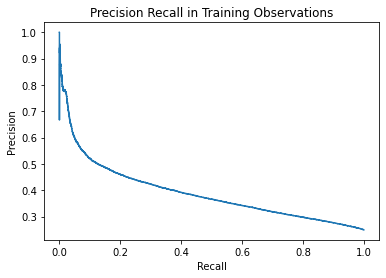

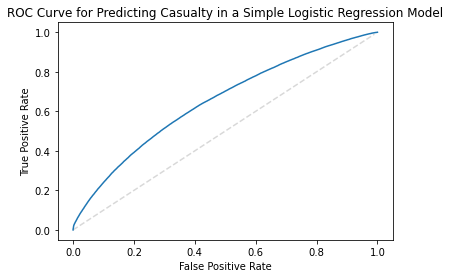

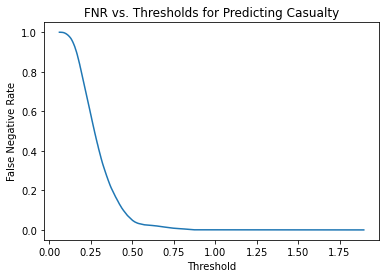

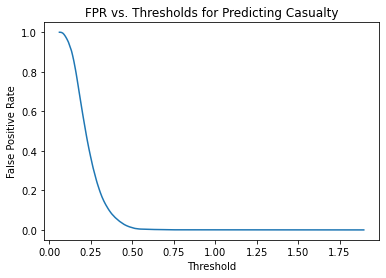

The performance metrics for test are:
Prediction accuracies: 0.7538908080772108
f1 score: 0.6655452943789884
Calculated false positive rate: 0.24326239845893835
Calculated false negative rate: 0.38461538461538464


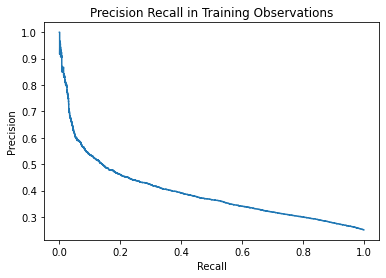

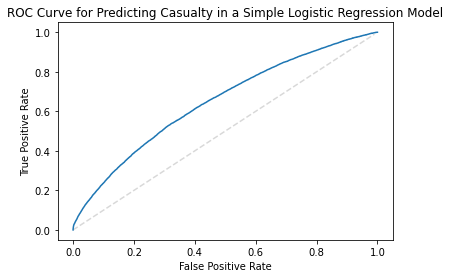

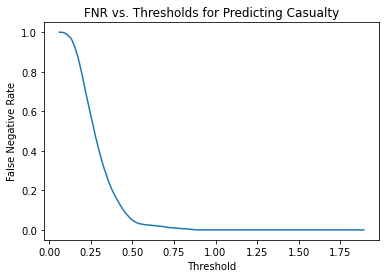

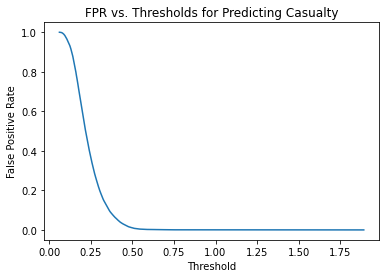

In [53]:
# Predict
y_pred_train = model_lasso.predict(X_train)
y_pred_test = model_lasso.predict(X_test)
y_pred_proba_train = model_lasso.predict_proba(X_train)[:,1]
y_pred_proba_test = model_lasso.predict_proba(X_test)[:,1]

#Perfromance Evaluation
print('')

# Get model performance metrics
train_pos, train_neg = bundle_performance_metric(y_train,y_pred_train,y_pred_proba_train,'train','lasso_1_1')
test_pos, test_neg = bundle_performance_metric(y_test,y_pred_test,y_pred_proba_test,'test','lasso_1_1')

### 3-2-1 Improved model with selected threshold

In [54]:
ideal_rate = 0.01

best_threshold, best_ind_train = findBestThreshold(np.flip(train_pos[0]),np.flip(train_neg[0]),np.flip(train_neg[2]),ideal_rate)
print(f'To achieve {ideal_rate} in false positive rate and false negative rate')
print(f'The best threshold is {best_threshold}')

To achieve 0.01 in false positive rate and false negative rate
The best threshold is 0.7286231857471424


The performance metrics for train are:
Prediction accuracies: 0.7527612196110031
f1 score: 0.6497604823019363
Calculated false positive rate: 0.24736811545006676
Calculated false negative rate: 0.20810810810810812


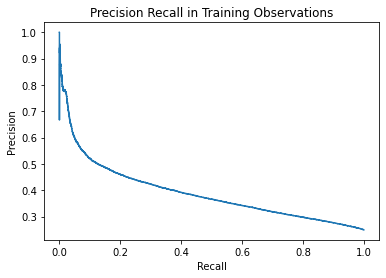

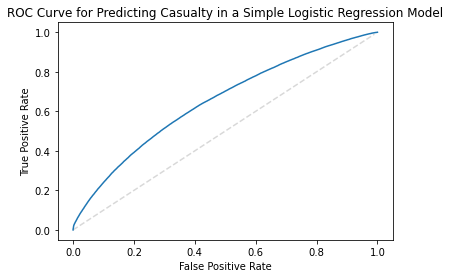

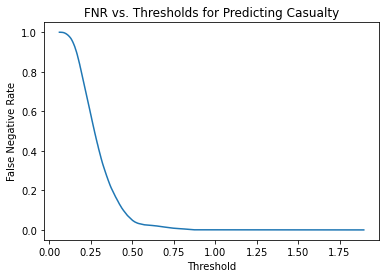

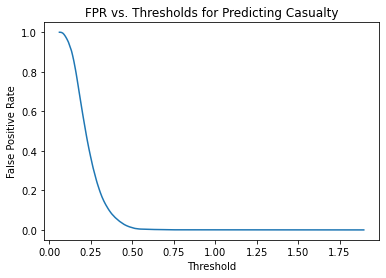

The performance metrics for test are:
Prediction accuracies: 0.751664945332811
f1 score: 0.6483969294083399
Calculated false positive rate: 0.24869568324757005
Calculated false negative rate: 0.14210526315789473


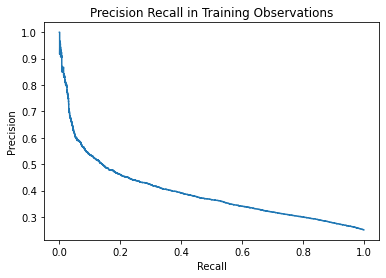

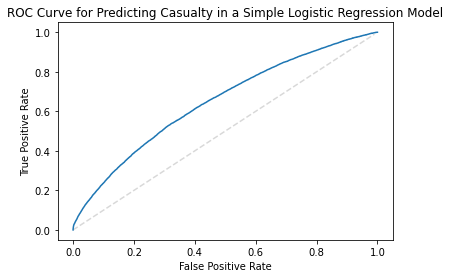

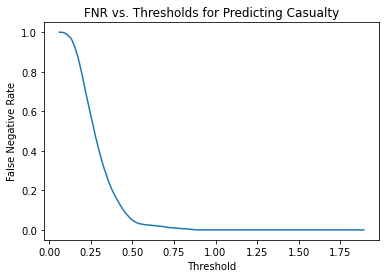

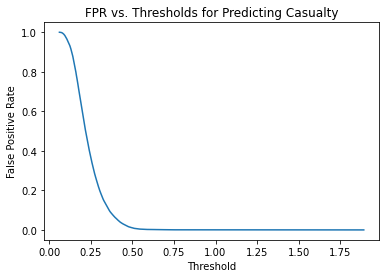

In [55]:
y_pred_th_train = predict_with_threshold(y_pred_proba_train,best_threshold)
y_pred_th_test = predict_with_threshold(y_pred_proba_test,best_threshold)

# Get model performance metrics
_,_ = bundle_performance_metric(y_train,y_pred_th_train,y_pred_proba_train,'train','lasso_1_2')
_,_ = bundle_performance_metric(y_test,y_pred_th_test,y_pred_proba_test,'test','lasso_1_2')

## 3-3 Decision Tree

### 3-3-1 Vanila Decision Tree

In [25]:
# Helper function for cross-validation
def calc_meanstd(X_train, y_train, depths, cv):
    """Performs cross-validation at varying tree depths
    
    This function fits decision tree classifiers at varying
    max tree-depths using cross-validation and provides lists
    training and mean and standard deviation validation scores
    for each specified tree depth.
    
    :param X_train: np.ndarray, 2-d array of training X values
    :param y_train: np.ndarray, 1-d array of training y values
    :param depth: list, depths at which to fit decision trees
    :param cv: int, number of folds at which to perform CV
    :returns: (list, list, list), a list of mean validation
              scores, a list of validation standard deviations,
              a list of train scores (based on models fit to the
              full training set)
    """
    cvmeans = []
    cvstds = []
    train_scores = []
    
    for depth in depths:
        clf = DecisionTreeClassifier(max_depth=depth)
        # calculate training score and save to list
        train_scores.append(clf.fit(X_train, y_train).score(X_train, y_train))
        # perform 5-fold CV and save mean and std to lists
        scores = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=cv)
        cvmeans.append(scores.mean())
        cvstds.append(scores.std())
        
    return cvmeans, cvstds, train_scores

def plot_cv_results(
    depths,
    cvmeans,
    cvstds,
    train_scores,
    title,
    limit_y=False,
    show_legend=True,
):
    """Generate plot of decision tree results at various depths
    
    Generates plot illustrating training and cross-validation
    accuracy score results for single decision tree classifiers
    fit at varying max depths. One line represents training
    scores and another line represents mean validation scores
    with +/-2 standard deviation bounds around those mean
    scores.
    
    :param depths: list, depths at which decision trees were fit
    :param cvmeans: np.ndarray, mean cross-validation scores at
                    each depth
    :param cvstd: np.ndarray, standard deviation cross-
                  validation scores at each depth 
    :param train_scores: np.ndarray, training scores (using the
                         full training set) at each depth
    :param title: str, plot title text
    :param limit_y: bool, whether to limit y-axis to just range
                    of validation means and +/-2 standard
                    deviations (default is False)
    :param show_legend: bool, whether to show legend on plot
                    (default=True)
    """
    plt.figure(figsize=(9, 4.5))
    plt.plot(
        depths,
        cvmeans,
        "^-",
        label="Mean validation",
        markeredgecolor="k",
        color="tab:orange",
        alpha=0.7,
        linewidth=2,
    )
    plt.fill_between(
        depths,
        cvmeans - 2*cvstds,
        cvmeans + 2*cvstds,
        color="tab:orange",
        alpha=0.3,
        label="Validation +/-2 standard deviations",
    )
    
    if limit_y:
        ylim = plt.ylim()
        plt.ylim(ylim)
    
    plt.plot(
        depths,
        train_scores,
        "o--",
        label="Training",
        color="tab:blue",
        alpha=0.4,
        linewidth=2,
    )

    if show_legend:
        plt.legend(fontsize=12)
    
    plt.ylabel("Accuracy", fontsize=12)
    plt.xlabel("Maximum tree depth", fontsize=12)
    plt.title(title, fontsize=14)
    plt.xticks(depths)
    plt.grid(":", alpha=0.4)
    plt.tight_layout()
    plt.show()

In [26]:
#Find optimal depth of trees
mean_CV_acc = {}
all_CV_acc = {}
tree_depth_start, tree_depth_end, steps = 1, 20, 1
cv=5

for i in range(tree_depth_start, tree_depth_end + 1, steps):
    
    #declare tree model object
    model = DecisionTreeClassifier(max_depth=i)
    
    #get cv scores
    scores = cross_val_score(estimator=model, X=X_train, y=y_train, cv=5, n_jobs=-1)
    
    all_CV_acc[i] = scores
    mean_CV_acc[i] = scores.mean()

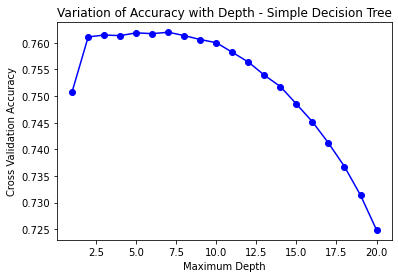

In [27]:
plot_x = list(mean_CV_acc.keys())
plot_y = list(mean_CV_acc.values())
lists = sorted(mean_CV_acc.items())
x, y = zip(*lists)  
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Maximum Depth")
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
plt.plot(x, y, 'b-', marker='o')
plt.show()

In [28]:
best_depth = sorted(mean_CV_acc,key=mean_CV_acc.get,reverse=True)[0]
best_score = sorted(plot_y,reverse=True)[0]
print(best_depth,best_score)

7 0.7619719646808797


### 3-3-2 Decision Tree with Selected Depth

In [29]:
from sklearn.metrics import classification_report
fitted_tree =  DecisionTreeClassifier(max_depth=best_depth).fit(X_train, y_train)

# prediction
y_pred_train = fitted_tree.predict(X_train)
y_pred_test = fitted_tree.predict(X_test)
y_pred_proba_train = fitted_tree.predict_proba(X_train)
y_pred_proba_test = fitted_tree.predict_proba(X_test)

fitted_tree_train_score = fitted_tree.score(X_train,y_train)
fitted_tree_test_score = fitted_tree.score(X_test,y_test)


In [30]:
# Save model predictions to file
fname = 'Decision_Tree'
fpath = '.\data\Accident_with_Prediction'
append_predict(X_train,X_test,y_pred_train, y_pred_test, y_pred_prob_train,y_pred_prob_test,fpath+fname)

Prediction combined with train and test data is saved at .\data\Accident_with_PredictionDecision_Tree


The performance metrics for train are:
Prediction accuracies: 0.7635078284638226
f1 score: 0.6961081643810052
Calculated false positive rate: 0.2304731422599413
Calculated false negative rate: 0.3617909867909868


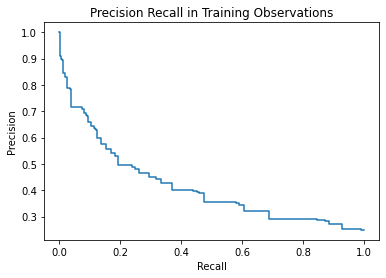

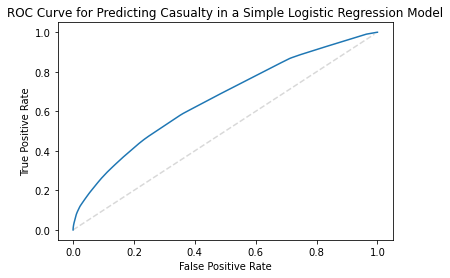

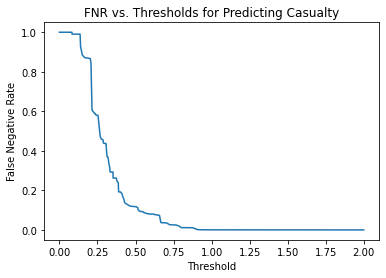

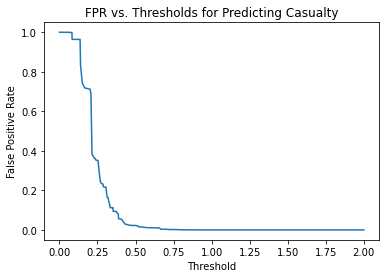

The performance metrics for test are:
Prediction accuracies: 0.759856120232202
f1 score: 0.692266501274772
Calculated false positive rate: 0.232803738317757
Calculated false negative rate: 0.38788562829194884


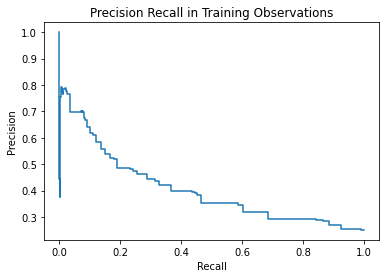

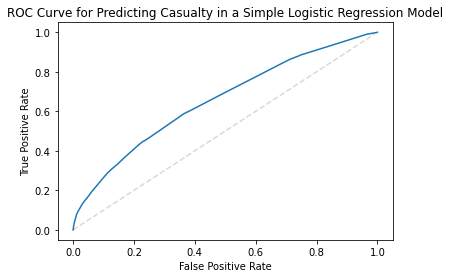

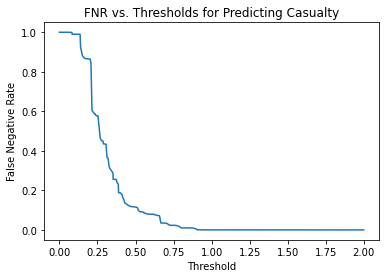

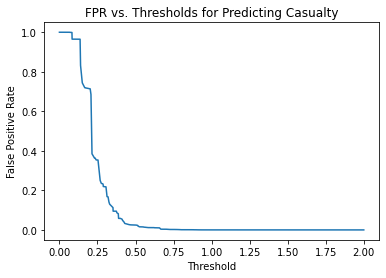

In [31]:
# Get model performance metrics
train_pos, train_neg = bundle_performance_metric(y_train,y_pred_train,y_pred_proba_train[:,1],'train','dt_1')
test_pos, test_neg = bundle_performance_metric(y_test,y_pred_test,y_pred_proba_test[:,1],'test','dt_1')

### 3-3-3 Random Forest

The performance metrics for train are:
Prediction accuracies: 0.7561890940172462
f1 score: 0.6594031269203486
Calculated false positive rate: 0.24424114220527537
Calculated false negative rate: 0.19523326572008112


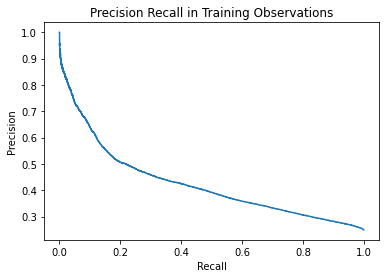

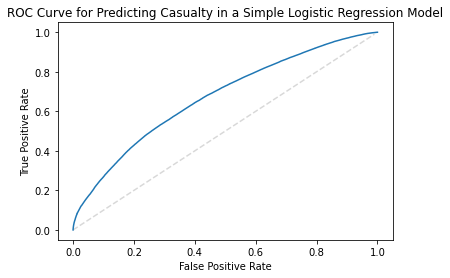

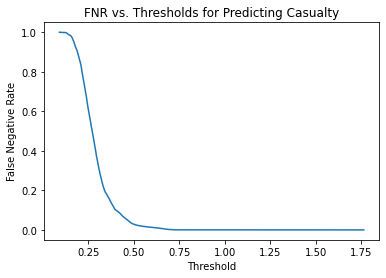

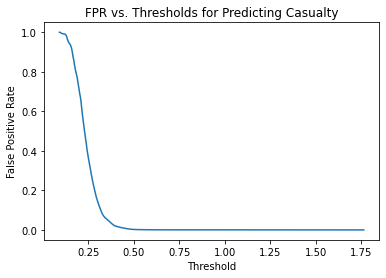

The performance metrics for test are:
Prediction accuracies: 0.7545852772534635
f1 score: 0.6571328015748277
Calculated false positive rate: 0.2458866216410404
Calculated false negative rate: 0.19135802469135801


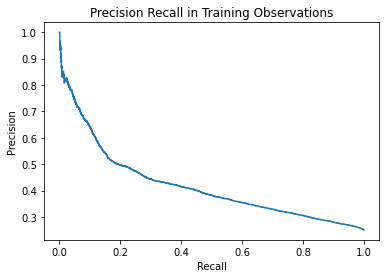

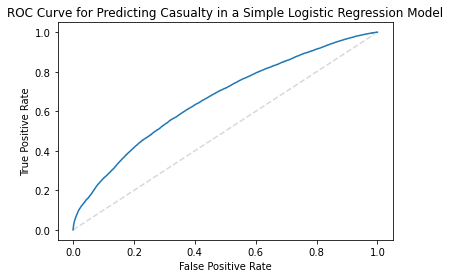

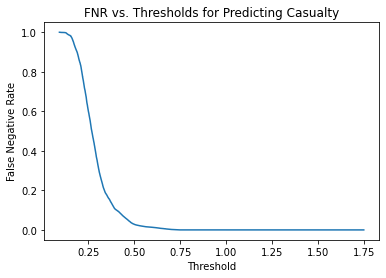

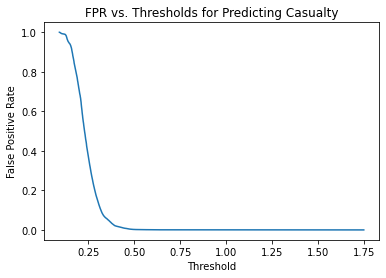

In [32]:
n_trees = 50

fitted_rf = RandomForestClassifier(
    n_estimators=n_trees, max_features="sqrt", max_depth=best_depth
).fit(X_train,y_train)

y_pred_train = fitted_rf.predict(X_train)
y_pred_test = fitted_rf.predict(X_test)
y_pred_proba_train = fitted_rf.predict_proba(X_train)
y_pred_proba_test = fitted_rf.predict_proba(X_test)

# Get model performance metrics
train_pos, train_neg = bundle_performance_metric(y_train,y_pred_train,y_pred_proba_train[:,1],'train','rf')
test_pos, test_neg = bundle_performance_metric(y_test,y_pred_test,y_pred_proba_test[:,1],'test','rf')

In [33]:
# Save model predictions to file
fname = 'Random_Forest'

append_predict(X_train,X_test,y_pred_train, y_pred_test, y_pred_prob_train,y_pred_prob_test,fpath+fname)

Prediction combined with train and test data is saved at .\data\Accident_with_PredictionRandom_Forest


In [34]:
# extract top predictors from fitted random forest trees
top_predictors_rf = [
    X_train.columns[model.tree_.feature[0]]
    for  model in fitted_rf.estimators_ 
]
# convert results to a pandas series
top_predictors_rf_df = pd.DataFrame(
    pd.Series(top_predictors_rf).value_counts(),
    columns=["Count"],
)
# display results
print(
    f'Random forest "top predictor" frequencies for '
    f"each of the {n_trees} ensemble trees:"
)
display(top_predictors_rf_df)

Random forest "top predictor" frequencies for each of the 50 ensemble trees:


Count
Ctb_Dangerous        9
Ctb_Improper         8
Collision_count      6
Daylight             5
Veh_Single           5
Veh_Large            4
ZIP CODE             3
MANHATTAN            2
Time_21_0            2
Speed_limit          1
BROOKLYN             1
Ctb_Inability        1
Time_18_21           1
Time_9_12            1
Veh_Medium           1

### 3-3-4 Lasso with interactions with important predictors

In [35]:
important = top_predictors_rf_df.index.values
Poly = PolynomialFeatures(
    interaction_only=True, include_bias=False
).fit(X_train[important])

all_colnames = Poly.get_feature_names(important)

X_train6 = X_train.copy()
X_test6 = X_test.copy()
X_train6[all_colnames] = Poly.transform(X_train6[important])
X_test6[all_colnames] = Poly.transform(X_test6[important])

# # create interaction_colnames list to be consistent with other 2 examples
interaction_colnames = [
    col for col in all_colnames
    if col not in important
]

C:\Users\Mirah\Anaconda2\envs\cs109a\lib\site-packages\pandas\core\frame.py:3673: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
C:\Users\Mirah\Anaconda2\envs\cs109a\lib\site-packages\pandas\core\frame.py:3673: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)


In [36]:
# your code here
logit_lasso_interact_predictors = np.concatenate((important, interaction_colnames))
Cs = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]
max_iter = 500
penalty = "l1"

solver = "liblinear"

logit_lasso_interact = LogisticRegressionCV(
    Cs=Cs, cv=10, penalty=penalty, max_iter=max_iter, solver=solver
).fit(X_train6[logit_lasso_interact_predictors], y_train)

logit_lasso_interact_coefs = logit_lasso_interact.coef_[0]
logit_lasso_interact_intercept = logit_lasso_interact.intercept_

In [37]:
accuracy_train_logit_lasso_interact = logit_lasso_interact.score(
    X_train6[logit_lasso_interact_predictors], y_train
)
accuracy_test_logit_lasso_interact = logit_lasso_interact.score(
    X_test6[logit_lasso_interact_predictors], y_test
)

print(
    "The intercept and coefficients for the 'logit_lasso_interact' model are:"
    "\n\n\t{:<30}{:.4f}".format(
        "intercept", logit_lasso_interact_intercept[0]
    )
)

for predictor, coef in zip(logit_lasso_interact_predictors, logit_lasso_interact_coefs):
    print("\t{:<30}{:.4f}".format(predictor, coef))

print(
    "\nThe classification accuracies for 'logit_lasso_interact' are:"
    "\n\n\tTrain\t{:.4f}\n\tTEST\t{:.4f}"
    .format(accuracy_train_logit_lasso_interact, accuracy_test_logit_lasso_interact)
)

print()

# # store test score to dict for later use
# all_accuarcy["logit_lasso_interact"] = accuracy_test_logit_lasso_interact

The intercept and coefficients for the 'logit_lasso_interact' model are:

	intercept                     -0.4967
	Ctb_Dangerous                 2.1638
	Ctb_Improper                  0.4980
	Collision_count               -0.1712
	Daylight                      0.9426
	Veh_Single                    -1.2599
	Veh_Large                     -1.7408
	ZIP CODE                      -0.0001
	MANHATTAN                     -0.6212
	Time_21_0                     -0.1595
	Speed_limit                   -0.1173
	BROOKLYN                      0.0956
	Ctb_Inability                 2.1383
	Time_18_21                    1.0126
	Time_9_12                     -0.2711
	Veh_Medium                    -1.1095
	Ctb_Dangerous Ctb_Improper    0.0000
	Ctb_Dangerous Collision_count -0.2379
	Ctb_Dangerous Daylight        0.0063
	Ctb_Dangerous Veh_Single      0.1572
	Ctb_Dangerous Veh_Large       -0.2798
	Ctb_Dangerous ZIP CODE        -0.0001
	Ctb_Dangerous MANHATTAN       -0.0421
	Ctb_Dangerous Time_21_0       -0.0963

In [38]:
# your code here
number_coefs = len(logit_lasso_interact_coefs)
number_important_coefs = sum(logit_lasso_interact_coefs != 0)
number_unimportant_coefs = number_coefs - number_important_coefs 

print(
    "Of the {} predictors used in our 'logit_lasso_interact' model:"
    "\n\n\t{} predictors were deemed 'important' by our model"
    "\n\t{} predictors were deemed 'unimportant' with 0-valued "
    "coefficients".format(
        number_coefs, number_important_coefs, number_unimportant_coefs
    )
)

Of the 120 predictors used in our 'logit_lasso_interact' model:

	109 predictors were deemed 'important' by our model
	11 predictors were deemed 'unimportant' with 0-valued coefficients


The performance metrics for train are:
Prediction accuracies: 0.7560688958237806
f1 score: 0.670080341287259
Calculated false positive rate: 0.24078947368421053
Calculated false negative rate: 0.38224093004610143


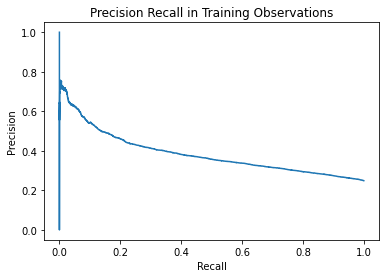

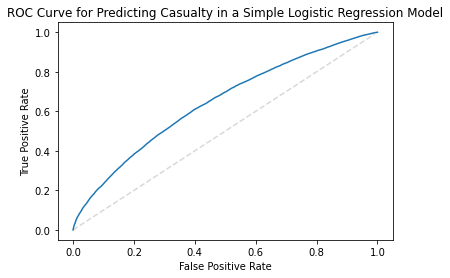

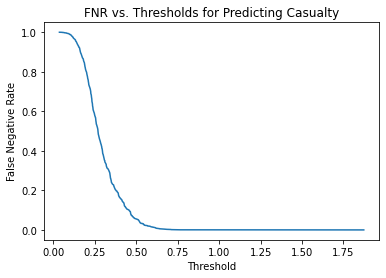

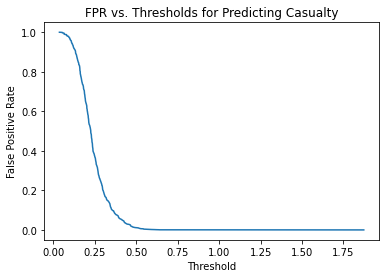

The performance metrics for test are:
Prediction accuracies: 0.7547455393710603
f1 score: 0.6691641862079953
Calculated false positive rate: 0.24198224150819553
Calculated false negative rate: 0.38215102974828374


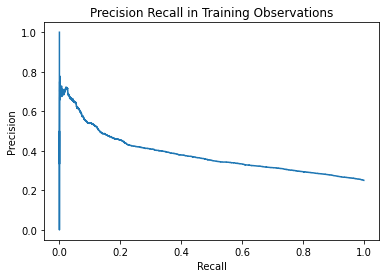

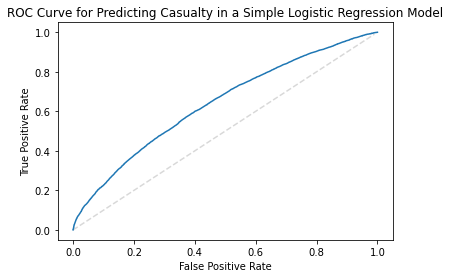

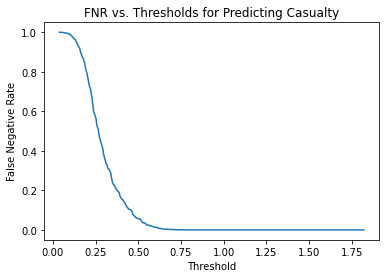

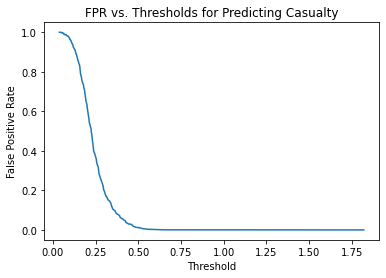

In [39]:
# Predicting
y_pred_train = logit_lasso_interact.predict( X_train6[logit_lasso_interact_predictors])
y_pred_test = logit_lasso_interact.predict(X_test6[logit_lasso_interact_predictors])
y_pred_proba_train = logit_lasso_interact.predict_proba(X_train6[logit_lasso_interact_predictors])
y_pred_proba_test = logit_lasso_interact.predict_proba(X_test6[logit_lasso_interact_predictors])

# Get model performance metrics
train_pos, train_neg = bundle_performance_metric(y_train,y_pred_train,y_pred_proba_train[:,1],'train','lasso_4')
test_pos, test_neg = bundle_performance_metric(y_test,y_pred_test,y_pred_proba_test[:,1],'test','lasso_4')

In [40]:
ideal_rate = 0.0

best_threshold_train, best_ind_train = findBestThreshold(np.flip(train_pos[0]),np.flip(train_neg[0]),np.flip(train_neg[2]),ideal_rate)
print(f'To achieve {ideal_rate} in false positive rate and false negative rate')
print(f'The best threshold is {best_threshold_train}')

To achieve 0.0 in false positive rate and false negative rate
The best threshold is 0.7718106985607671


In [46]:
len(y_pred_proba_train[:,0])

224629

The performance metrics for train are:
Prediction accuracies: 0.7508825663649841
f1 score: 0.6442335502009892
Calculated false positive rate: 0.249090544782599
Calculated false negative rate: 0.38636363636363635


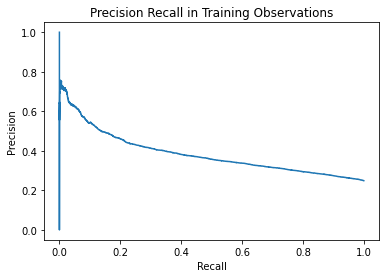

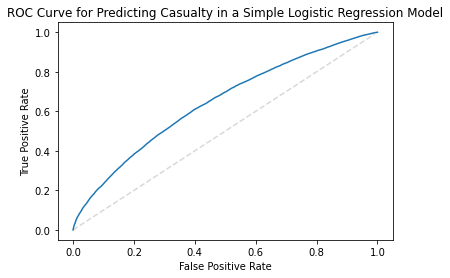

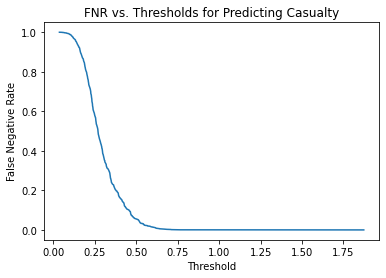

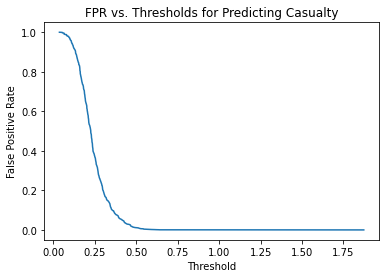

The performance metrics for test are:
Prediction accuracies: 0.7492075928629937
f1 score: 0.6418873839175349
Calculated false positive rate: 0.2507479697962673
Calculated false negative rate: 0.6666666666666666


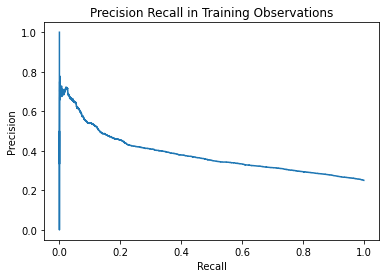

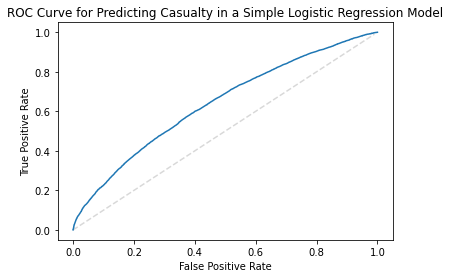

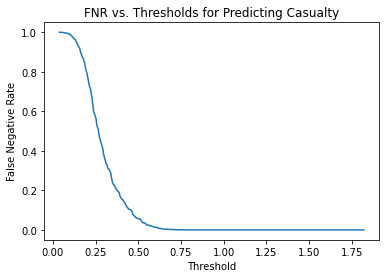

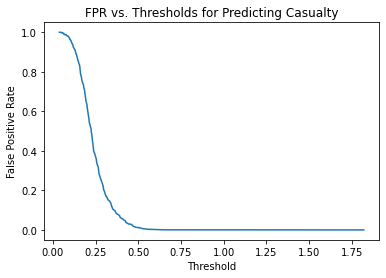

In [48]:
y_pred_th_train = predict_with_threshold(y_pred_proba_train[:,1],best_threshold_train)
y_pred_th_test = predict_with_threshold(y_pred_proba_test[:,1],best_threshold_train)

# Get model performance metrics
_,_ = bundle_performance_metric(y_train,y_pred_th_train,y_pred_proba_train[:,1],'train','lasso_4_2')
_,_ = bundle_performance_metric(y_test,y_pred_th_test,y_pred_proba_test[:,1],'test','lasso_4_2')

## 3-4. Models Performance Comparison

In [56]:
# Plotting all the 
best_model_acc = max(all_accuarcy, key=all_accuarcy.get)
best_accuarcy = max(all_accuarcy.values())
print(f"The Best Model by accuarcy is: {best_model_acc}, {best_accuarcy}")

The Best Model by accuarcy is: dt_1, 0.7635078284638226


In [57]:
all_fpr, all_fnr = {},{}
for key in all_calc_fpr_fnr:
    all_fpr[key] = all_calc_fpr_fnr[key][0]
    all_fnr[key] = all_calc_fpr_fnr[key][1]

best_model_fpr = min(all_fpr)
best_fpr = min(all_fpr.values())

best_fnr = min(all_fnr.values())
best_model_fnr = list(all_fnr.keys())[list(all_fnr.values()).index(min(all_fnr.values()))]

print(f"The Best Model by FPR is: {best_model_fpr}, {best_fpr}")
print(f"The Best Model by FNR is: {best_model_fnr}, {best_fnr}")

The Best Model by FPR is: dt_1, 0.2304731422599413
The Best Model by FNR is: rf, 0.19523326572008112


In [85]:
model_names = ['M1','M2','M2_th','M3','M3_th','M4','M4_th','M5','M6','M7','M7_th']

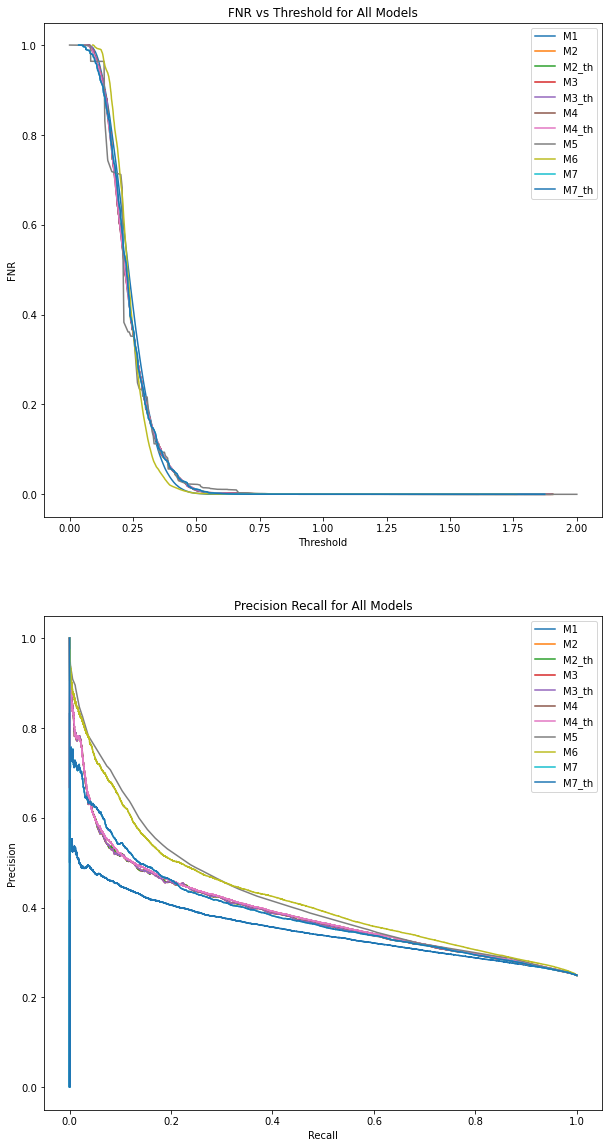

In [87]:
# plot all the FPR & FNR of different models
fig,ax = plt.subplots(2,1,figsize=[10,20])
for i,key in enumerate (all_roc.keys()):
#     print(i)
#     print(key)
    ax[0].plot(all_roc[key][2],all_roc[key][0],label=model_names[i])
    ax[0].set_xlabel('Threshold')
    ax[0].set_ylabel('FNR')
    ax[0].set_title('FNR vs Threshold for All Models')
    ax[0].legend()
#     ax[0].show()
    
    ax[1].plot(all_precision_recall[key][1],all_precision_recall[key][0],label=model_names[i])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision Recall for All Models')
    ax[1].legend()

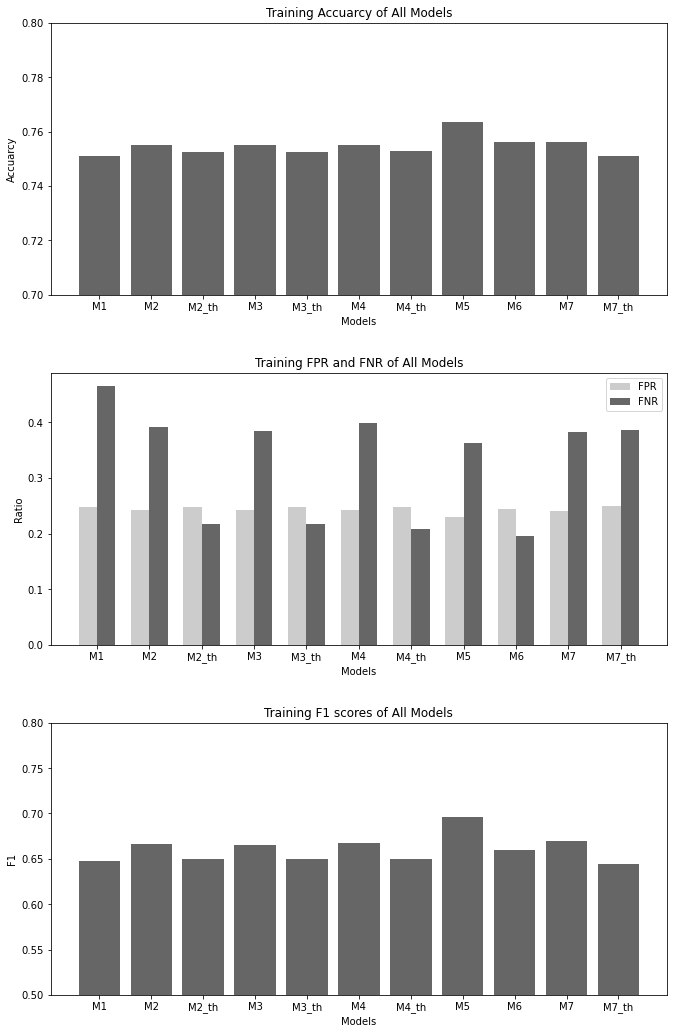

In [106]:
fig,ax = plt.subplots(3,1,figsize=[10,15])
N = len(model_names)
ind = np.arange(N)
width=0.35

# Plot all model accuarcy 
ax[0].bar(ind,all_accuarcy.values(),color='0.4')
ax[0].set_ylim(0.7,0.8)
ax[0].set_xlabel('Models')
ax[0].set_ylabel('Accuarcy')
ax[0].set_xticks(ind)
ax[0].set_xticklabels(model_names)
ax[0].set_title('Training Accuarcy of All Models')

# Plot all FNR & FPR 
data2 = ax[1].bar(ind,all_fpr.values(),label='FPR',width=width,color='0.8')
data1 = ax[1].bar(ind+width,all_fnr.values(),label='FNR',width=width,color='0.4')
ax[1].set_xlabel('Models')
ax[1].set_ylabel('Ratio')
ax[1].set_title('Training FPR and FNR of All Models')
ax[1].set_xticks(ind + width / 2)
ax[1].set_xticklabels(model_names)
ax[1].legend()

# Plot all f1 score
ax[2].bar(ind,all_f1.values(),color='0.4')
ax[2].set_xlabel('Models')
ax[2].set_ylabel('F1')
ax[2].set_ylim(0.5,0.8)
ax[2].set_xticks(ind)
ax[2].set_xticklabels(model_names)
ax[2].set_title('Training F1 scores of All Models')

fig.tight_layout(pad=3.0)

# 4. Rank System Visualization

In [2]:
import folium
from folium import plugins
import numpy as np
import pandas as pd
import json
import requests
import branca
from branca.element import Figure

pd.options.mode.chained_assignment = None  # default='warn'

In [6]:
path = %pwd
df1 = pd.read_csv("./data/Accident_with_PredictionRandom_Forest_test.csv", low_memory=False)
df1 = df1.rename(columns={"Unnamed: 0": "index"})

In [9]:
df2 = pd.read_csv("./data/Accident+weather_merged.csv", low_memory=False)
df2 = df2.reset_index()

In [10]:
df1["Vehicle Type"] = np.where(df1["Veh_Small"] == 1, "Veh_Small", np.where(df1["Veh_Single"] == 1, "Veh_Single"
                                                                          , np.where(df1["Veh_Medium"] == 1, "Veh_Medium", np.where(df1["Veh_Large"] == 1, "Veh_Large", "Not specified"))))

In [11]:
df = pd.merge(df1, df2, how = "left", on = "index")
df = df[["Datetime", "Latitude", "Longitude", "LOCATION", "BOROUGH", "ON STREET NAME", "Vehicle Type",  "Casualty_Prediction", "Casualty_Prediction_Probability"]]

In [12]:
time_from = '2020-11-11 12:00:00'
time_to = '2020-11-11 15:00:00'

df_vis = df[(df["Datetime"] > time_from) & (df["Datetime"] < time_to)].sort_values(by= ["Casualty_Prediction", "Casualty_Prediction_Probability"], ascending = False)
df_temp = df_vis[["Datetime", "LOCATION", "BOROUGH", "ON STREET NAME", "Vehicle Type"]].reset_index().drop("index", axis = 1)

In [13]:
#Tiles
# OpenStreetMap
# Stamen (Terrain, Toner, and Watercolor)
# CartoDB Positron

fig = Figure(width=900 ,height=700)
m = folium.Map(location = [40.690440, -74.004477], tiles = "CartoDB Positron"
               , zoom_start = 11, zoom_control=False, scrollWheelZoom=True, dragging=True)
fig.add_child(m)


geo_data = "https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/new-york-city-boroughs.geojson"

folium.Choropleth(geo_data = geo_data, fill_color = "slategray", fill_opacity = 0.2, line_opacity = 0.5).add_to(m)


for i in range(df_vis.shape[0]):
    html = df_temp.iloc[i:i+1].reset_index().drop("index", axis = 1).to_html(classes = "table table-striped table-hover, table-condensed table-responsive")
    if df_vis["Casualty_Prediction_Probability"].iloc[i] > 0.25:
        icon_number = plugins.BeautifyIcon(number = i + 1, border_width = 3, border_color = "crimson", inner_icon_style = "font-weight: bold"
                                           , text_color = "crimson", icon_shape = "marker")
    else:
        icon_number = plugins.BeautifyIcon(number = i + 1, border_width = 3, border_color = "teal", inner_icon_style = "font-weight: bold"
                                           , text_color = "teal", icon_shape = "marker")
    folium.Marker([df_vis["Latitude"].iloc[i], df_vis["Longitude"].iloc[i]], popup = folium.Popup(html, max_width = 1000, max_height = 400), icon = icon_number).add_to(m)


loc = "New York City Real-time Accident Priority"
loc2 = time_from + " - " + time_to.split(" ")[-1]
title_html = '''
             <h3 align="center" style="font-size:18px"><b>{}</b></h3><h3 align="center" style="font-size:14px">{}</h3>
             '''.format(loc, loc2)  
fig.get_root().html.add_child(folium.Element(title_html))    

m.save("final_vis.html")
m

# 5. Accident Priortity by Zipcode

In [3]:
path = %pwd
df1 = pd.read_csv(path + "\Data\\Accident_with_PredictionRandom_Forest_test.csv", low_memory=False)
df1 = df1.rename(columns={"Unnamed: 0": "index"})

In [4]:
df1 = df1.groupby("ZIP CODE").mean().reset_index()
df1 = df1[["ZIP CODE", "Casualty_Prediction_Probability"]]
df1["Casualty_Prediction_Probability"] = df1["Casualty_Prediction_Probability"]*100

In [5]:
df1["ZIP CODE"] = df1["ZIP CODE"].astype(int).astype(str)

In [6]:
path = %pwd
zip_geo = path + "/data/Newyork_zip_boundary.json"

fig = Figure(width=850,height=450)
m3 = folium.Map(location = [40.688440, -74.019477], tiles = "CartoDB Positron")
fig.add_child(m3)


bins = list(df1["Casualty_Prediction_Probability"].quantile([0, 0.25, 0.5, 0.75, 1]))

folium.Choropleth(geo_data = zip_geo, data = df1, columns = ["ZIP CODE", "Casualty_Prediction_Probability"]
                  , key_on = "properties.postalCode", fill_color = 'YlOrRd'
                  , fill_opacity = 0.6, line_opacity = 0.2, legend_name = "Casualty_Prediction_Probability (%)", bins = bins).add_to(m3)


loc = "New York City Accident Priority by Zipcode"
title_html = ""'''
             <h3 align="center" style="font-size:18px"><b>{}</b></h3>
             '''.format(loc)
fig.get_root().html.add_child(folium.Element(title_html))


folium.LayerControl().add_to(m3)
m3.save("zip_vis.html")
m3
